In [1]:
#cd t:\freely_moving_ephys\ephys_recordings\101120\G6H28P6LT\hf4_wn
#cd \\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs_Oct07a
#cd t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\hf1_wn


In [2]:
cd t:\freely_moving_ephys\ephys_recordings\113020\G6H27P8LT\hf3_gratings

t:\freely_moving_ephys\ephys_recordings\113020\G6H27P8LT\hf3_gratings


In [3]:
ls *.nc

 Volume in drive T is New Volume
 Volume Serial Number is 14AE-E256

 Directory of t:\freely_moving_ephys\ephys_recordings\113020\G6H27P8LT\hf3_gratings

12/10/2020  01:57 AM       703,111,118 113020_G6H27P8LT_control_Rig2_hf3_gratings_Reye.nc
12/18/2020  10:09 PM           331,675 113020_G6H27P8LT_control_Rig2_hf3_gratings_speed.nc
12/18/2020  10:09 PM       630,977,602 113020_G6H27P8LT_control_Rig2_hf3_gratings_world.nc
12/18/2020  10:05 PM       587,717,198 113020_G6H27P8LT_control_Rig2_hf3_gratingsReye.nc
               4 File(s)  1,922,137,593 bytes
               0 Dir(s)  1,434,295,414,784 bytes free


In [386]:
eye_file =   "101120_G6H28P6LT_hf4_wnReye.nc"
world_file = '101120_G6H28P6LT_hf4_wnworld.nc'
ephys_file = '101120_G6H28P6LT_hf4_wn_ephys.json'

eye_file = '092820_J524RT_whitenoise_hfReye.nc'
world_file = '092820_J524RT_whitenoise_hfworld.nc'
ephys_file = '092820_J524RT_whitenoise_hf_ephys.json'

eye_file =   "101420_G6H28P6LT_hf1_wnReye.nc"
world_file = '101420_G6H28P6LT_hf1_wnworld.nc'
ephys_file = '101420_G6H28P6LT_hf1_wn_ephys_merge.json'

eye_file =   "101420_G6H28P6LT_h2_wn_Reye.nc"
world_file = '101420_G6H28P6LT_h2_wn_world.nc'
ephys_file = '101420_G6H28P6LT_h2_wn_ephys_merge.json'

#name_base = '112920_G6H27P8LT_control_Rig2_hf1_wn'
name_base = '113020_G6H27P8LT_control_Rig2_hf3_gratings'

eye_file = name_base + 'Reye.nc'
world_file = name_base + '_world.nc'
ephys_file = name_base + '_ephys_merge.json'
imu_file = name_base + "_imu.nc"
speed_file = name_base + "_speed.nc"

#free_move = True; has_imu = True; has_mouse = False;
free_move = False; has_imu = False; has_mouse = True;
stim_type = 'grat'


True


In [326]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
import subprocess
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan
from util.aux_funcs import nanxcorr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.ndimage import shift as imshift
from scipy import signal
from sklearn.cluster import KMeans

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## load worldcam

In [6]:
# load worldcam
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])



In [7]:
#resize worldcam to make more manageable
sz = world_vid_raw.shape
downsamp = 0.5
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps.copy()
world_data

<xarray.Dataset>
Dimensions:      (frame: 19375, height: 240, width: 320)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 5 ... 19370 19371 19372 19373 19374
    timestamps   (frame) float64 ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8 13 111 26 102 92 ... 81 82 85 85 88

Text(0.5, 0, 'deltaT')

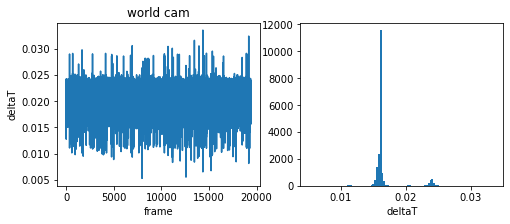

In [8]:
# plot worldcam timing
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(worldT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('world cam')
axs[1].hist(np.diff(worldT),100);axs[1].set_xlabel('deltaT')

Text(0.5, 1.0, 'mean worldcam')

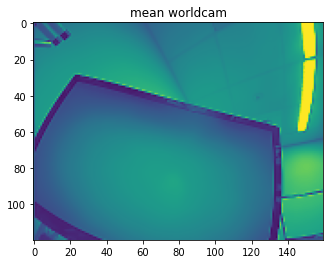

In [9]:
# plot mean world image
plt.imshow(np.mean(world_vid,axis=0)); plt.title('mean worldcam')

In [10]:
# read ephys data
ephys_data = pd.read_json(ephys_file)
ephys_data['spikeTraw'] = ephys_data['spikeT']


In [11]:
# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

40991.239782

In [12]:
# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values


In [13]:
# get number of good units
n_units = len(goodcells)
print(n_units)

19


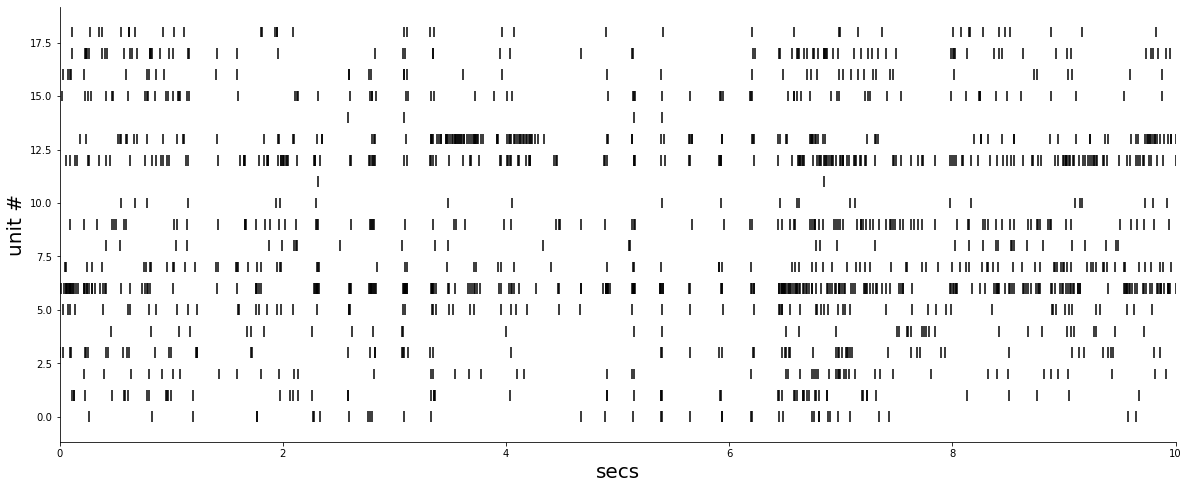

In [14]:
#spike rasters
fig, ax = plt.subplots(figsize=(20,8))
ax.fontsize = 20
for i,ind in enumerate(goodcells.index):
   plt.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25)
   plt.xlim(0, 10); plt.xlabel('secs',fontsize = 20); plt.ylabel('unit #',fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('spikeraster.pdf')



<xarray.DataArray 'timestamps' (frame: 19378)>
array([40990.32488625, 40990.33920275, 40990.35524725, ...,
       41313.59453775, 41313.61058225, 41313.62662675])
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 19373 19374 19375 19376 19377
    timestamps  (frame) float64 4.099e+04 4.099e+04 ... 4.131e+04 4.131e+04

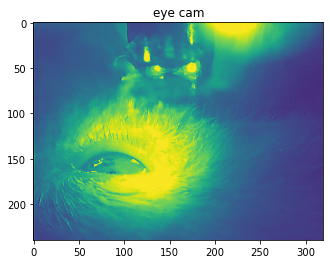

In [15]:
#load eye data
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps.copy()
eyeT

In [16]:
#omega = np.array(eye_data['REYE_eye_pupil_rotation'])*180/np.pi
#plt.subplot(2,1,1)
#plt.plot(eyeT,omega); plt.xlabel('secs'); plt.ylabel('pupil rotation deg')
#plt.subplot(2,1,2)
#plt.hist(omega); plt.xlabel('pupil rotation deg')

In [17]:
eye_data

<xarray.Dataset>
Dimensions:              (ellipse_params: 7, frame: 19378, height: 240, point_loc: 30, width: 320)
Coordinates:
  * frame                (frame) int64 0 1 2 3 4 ... 19374 19375 19376 19377
  * point_loc            (point_loc) object 'pt1_x' ... 'outer_likelihood'
    timestamps           (frame) float64 ...
  * ellipse_params       (ellipse_params) object 'theta' 'phi' ... 'ellipse_phi'
Dimensions without coordinates: height, width
Data variables:
    REYE_pts             (frame, point_loc) float64 ...
    REYE_ellipse_params  (frame, ellipse_params) float64 ...
    REYE_video           (frame, height, width) int8 12 94 73 76 ... 45 44 44 44

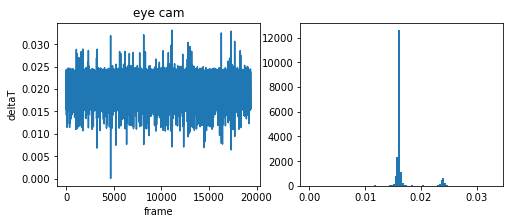

In [18]:
# plot eye timestamps
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(eyeT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('eye cam')
axs[1].hist(np.diff(eyeT),100);

Text(0, 0.5, 'phi')

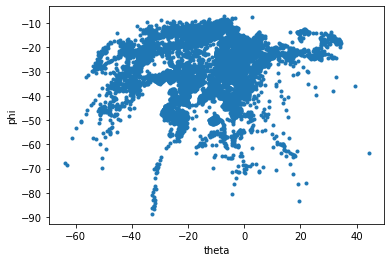

In [19]:
#plot eye postion across recording
eye_params = eye_data['REYE_ellipse_params']
plt.plot(eye_params.sel(ellipse_params = 'theta')*180/3.1415,eye_params.sel(ellipse_params = 'phi')*180/3.1415,'.')
plt.xlabel('theta'); plt.ylabel('phi')

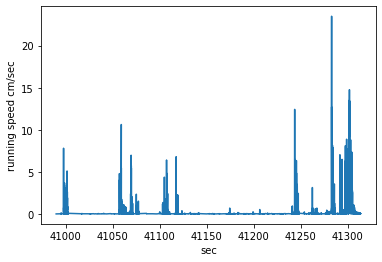

In [20]:
# load IMU data
if free_move & has_imu:
    imu_data = xr.open_dataset(imu_file)
    acc_chans = imu_data['__xarray_dataarray_variable__']
    gx = np.array(acc_chans.sel(channel='gyro_x'))
    gy = np.array(acc_chans.sel(channel='gyro_y'))
    gz = np.array(acc_chans.sel(channel='gyro_z'))

#load optical mouse data
if (free_move == False) & has_mouse:
    speed_data = xr.open_dataset(speed_file)
    spdVals = speed_data['__xarray_dataarray_variable__']
    spd = spdVals.sel(move_params = 'cm_per_sec')*10  # need to check conversion factor
    spd_tstamps = spdVals.sel(move_params = 'timestamps')
    plt.plot(spd_tstamps,spd)
    plt.xlabel('sec'); plt.ylabel('running speed cm/sec') 

In [21]:
# adjust eye/world/top times relative to ephys
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
if free_move & has_imu:
    accTraw = imu_data.timestamps-ephysT0
if (free_move==False) & has_mouse:
    speedT = spd_tstamps-ephysT0
eyeT, worldT

(<xarray.DataArray 'timestamps' (frame: 19378)>
 array([ -0.91489575,  -0.90057925,  -0.88453475, ..., 322.35475575,
        322.37080025, 322.38684475])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 19373 19374 19375 19376 19377
     timestamps  (frame) float64 4.099e+04 4.099e+04 ... 4.131e+04 4.131e+04,
 <xarray.DataArray 'timestamps' (frame: 19375)>
 array([ -0.89175375,  -0.87709125,  -0.86104675, ..., 322.32273625,
        322.34665275, 322.36269725])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 19370 19371 19372 19373 19374
     timestamps  (frame) float64 4.099e+04 4.099e+04 ... 4.131e+04 4.131e+04)

Text(0.5, 1.0, 'theta switch')

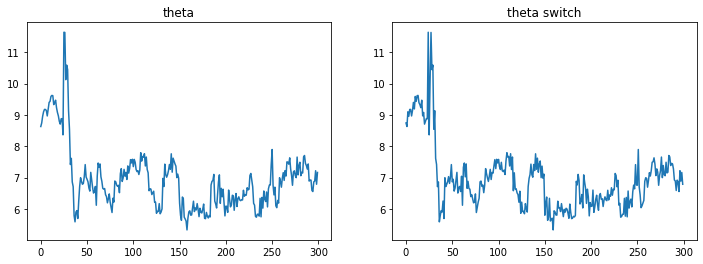

In [22]:
#check timing of eye movements - if de-interlacing is wrong, theta will look jagged, but switching order will fix it
th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
th_switch = np.zeros(np.shape(th))
th_switch[0:-1:2] = np.array(th[1::2])
th_switch[1::2] = np.array(th[0:-1:2])
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(th[(35*60):(40*60)]); plt.title('theta')
plt.subplot(1,2,2)
plt.plot(th_switch[(35*60):(40*60)]); plt.title('theta switch')

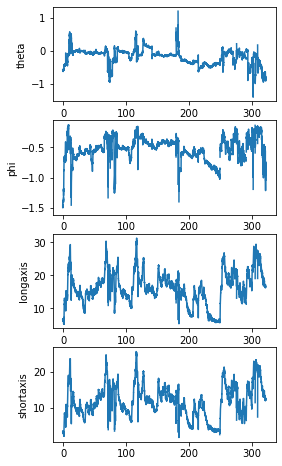

In [23]:
#plot eye variables
fig,axs = plt.subplots(4,1,figsize = (4,8))
for i,val in enumerate(eye_params.ellipse_params[0:4]):
    axs[i].plot(eyeT,eye_params.sel(ellipse_params = val))
    axs[i].set_ylabel(val.values)
    

In [24]:
# calculate eye veloctiy
dEye = np.diff(eye_params.sel(ellipse_params = 'theta'))*180/np.pi
eye_vid.shape

(19378, 240, 320)

In [25]:
# check accelerometer / eye temporal alignment
if free_move & has_imu:
    lag_range = np.arange(-0.2,0.2,0.002)
    cc = np.zeros(np.shape(lag_range))
    t1 = np.arange(5,1600,20)
    t2 = t1 + 60;
    offset = np.zeros(np.shape(t1))
    ccmax = np.zeros(np.shape(t1))
    acc_interp = interp1d(accTraw, (gz-3)*7.5)
    for tstart in range(len(t1)):
        for l in range(len(lag_range)):
            c, lag= nanxcorr(dEye[t1[tstart]*60 : t2[tstart]*60] + 0.5/60, acc_interp(eyeT[t1[tstart]*60:t2[tstart]*60]+lag_range[l]),1)
            cc[l] = c[1]
        offset[tstart] = lag_range[np.argmax(cc)]    
        ccmax[tstart] = np.max(cc)
    #plt.subplot(1,2,1)
    #plt.plot(lag_range,cc); plt.xlabel('lag'); plt.ylabel('cc'); plt.title(str(offset))
    #plt.subplot(1,2,2)
    #plt.plot(eyeT[0:-1],dEye,label = 'dEye')          
    #plt.plot(accT, (gz-3)*7.5, label = 'gyro')
    #plt.xlim(t1,t2)
    offset[ccmax<0.1] = nan;
    plt.subplot(1,2,1)
    plt.plot(eyeT[t1*60],offset)
    plt.xlabel('secs'); plt.ylabel('offset - secs')
    #print(ccmax)
    plt.subplot(1,2,2)
    plt.plot(eyeT[t1*60],ccmax)
    plt.xlabel('secs'); plt.ylabel('max cc')

In [26]:
# fit regression to timing drift
if free_move & has_imu:
    model = LinearRegression()
    dataT = np.array(eyeT[t1*60 + 30])
    model.fit(dataT[offset>0].reshape(-1,1),offset[offset>0])

    offset0 = model.intercept_
    drift_rate = model.coef_;


    plt.plot(dataT,offset,'.')
    plt.plot(dataT, offset0 + dataT*drift_rate)
    plt.xlabel('secs'); plt.ylabel('offset - secs')
    print(offset0)
    print(drift_rate)
if free_move == False:
    offset0 = 0.1;
    drift_rate = 0.1/1000;

In [27]:
#correct accelerometer and spike times
if free_move & has_imu:
    accT= accTraw - (offset0 + accTraw*drift_rate)
for i in range(len(ephys_data)):
    ephys_data['spikeT'].iloc[i] = np.array(ephys_data['spikeTraw'].iloc[i]) - (offset0 + np.array(ephys_data['spikeTraw'].iloc[i]) *drift_rate)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
ephys_data

Amplitude  ContamPct KSLabel        amp  ch  depth        fr  group  \
0        831.8      766.3     mua  38.779800   0      1  0.049973  noise   
1        280.2       38.3     mua  20.010872   3     76  4.739199  noise   
2        532.0      452.2     mua  35.837986   2     51  0.059507  noise   
3       1972.0      975.0     mua  36.393227   6    151  0.010192  noise   
4       1168.7     1657.5     mua  29.147697   0      1  0.012822  noise   
..         ...        ...     ...        ...  ..    ...       ...    ...   
202     2070.7        0.0    good  66.090561  59    676  2.447024  noise   
203     1656.4        7.3    good  76.581085  61    726  0.640770  noise   
204     1239.6       27.8     mua  90.319221  60    701  4.138539    mua   
205      923.9        0.0    good  59.331085  55    576  0.255782  noise   
206     1067.8        0.0     mua  64.763069  56    601  0.175891  noise   

     n_spikes  sh                                           waveform  \
0         152   0  [0.021200126, 0.0042820089, 0.006965057, 0.007...   
1       14415   0  [0.0482882597, 0.047045473000000004, 0.0448711...   
2         181   0  [-0.0248870458, -0.0280647129, -0.0328201316, ...   
3          31   0  [0.012948445000000001, 0.0351695046, 0.0400991...   
4          39   0  [-0.0095937969, -0.0073385406, -0.0070729619, ...   
..        ...  ..                                                ...   
202      7443   0  [0.0234736931, 0.0415179431, 0.039258651400000...   
203      1949   0  [0.0275271349, 0.0469120517, 0.0445312448, 0.0...   
204     12588   0  [0.0117258364, 0.0190299302, 0.0169364475, 0.0...   
205       778   0  [0.028043812100000003, 0.0486460105, 0.0465628...   
206       535   0  [0.0211261623, 0.0388512611, 0.036486201, 0.03...   

                                                spikeT            t0  \
0    [33.60596239996667, 46.56016684996667, 62.4365...  40991.239782   
1    [-0.027740559966670006, 0.67758890003333, 0.69...  40991.239782   
2    [22.0717826, 77.06228300000001, 96.64505785996...  40991.239782   
3                                                   []  40991.239782   
4                                                   []  40991.239782   
..                                                 ...           ...   
202  [0.18437156, 0.29336066000000005, 0.4081825099...  40991.239782   
203  [0.68925439996667, 0.94996166003333, 4.0675832...  40991.239782   
204  [-0.04487218003333, 0.33705629000000004, 0.412...  40991.239782   
205  [2.21560174996667, 8.03315327003333, 8.0383194...  40991.239782   
206  [1.60299635003333, 2.4973402399999998, 6.46294...  40991.239782   

                                             spikeTraw  
0    [33.7093333333, 46.6648333333, 62.5428, 70.041...  
1    [0.0722666667, 0.7776666667000001, 0.793733333...  
2    [22.174, 77.17, 96.7547333333, 105.8585333333,...  
3                                                   []  
4                                                   []  
..                                                 ...  
202  [0.2844, 0.3934, 0.5082333333, 0.5165000000000...  
203  [0.7893333333, 1.0500666667, 4.168, 7.133, 7.1...  
204  [0.055133333300000004, 0.43710000000000004, 0....  
205  [2.3158333333, 8.1339666667, 8.1391333333, 8.2...  
206  [1.7031666667, 2.5976, 6.5636, 8.2397666667, 8...  

[204 rows x 14 columns]

Text(0, 0.5, 'contrast')

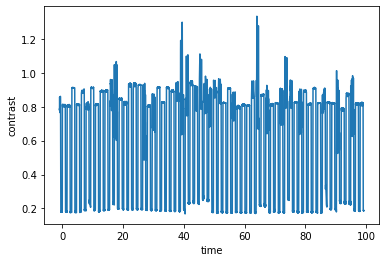

In [294]:
# normalize world movie and calculate contrast
cam_gamma = 2;
world_norm = (world_vid/255)**cam_gamma
std_im = np.std(world_norm,axis=0);
std_im[std_im<10/255] = 10/255;
img_norm = (world_norm-np.mean(world_norm,axis=0))/std_im

contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:6000],contrast[0:6000])
plt.xlabel('time')
plt.ylabel('contrast')

12.75

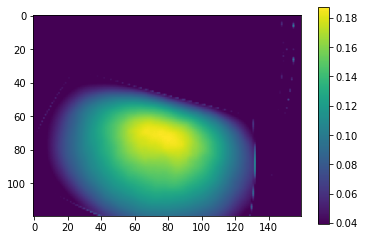

In [295]:
plt.imshow(std_im)
plt.colorbar()
0.05*255

In [30]:
# set up interpolators for eye and world videos
eyeInterp = interp1d(eyeT,eye_vid,axis=0)
worldInterp = interp1d(worldT,world_vid,axis=0)

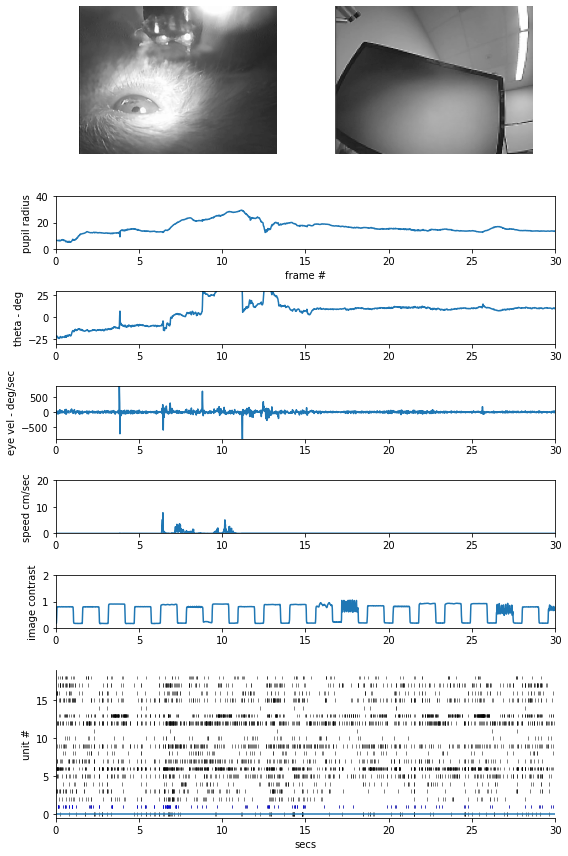

In [31]:
# make movie and sound

#unit to plot/record
this_unit = 1

#set up figure
fig = plt.figure(figsize = (8,12))
gs = fig.add_gridspec(9,4)
axEye = fig.add_subplot(gs[0:2,0:2])
axWorld = fig.add_subplot(gs[0:2,2:4])

axRad = fig.add_subplot(gs[2,:])
axTheta = fig.add_subplot(gs[3,:])
axdTheta = fig.add_subplot(gs[4,:])
axGyro = fig.add_subplot(gs[5,:])
axContrast = fig.add_subplot(gs[6,:])
axR = fig.add_subplot(gs[7:9,:])
#axRad = fig.add_subplot(gs[3,:])

#timerange and center frame (only)
tr = [0, 30]
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
#axEye.set_xlim(0,160); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

# plot contrast
axContrast.plot(worldT,contrast)
axContrast.set_xlim(tr[0],tr[1]); axContrast.set_ylim(0,2)
axContrast.set_ylabel('image contrast')


#plot radius
axRad.cla()
axRad.plot(eyeT,eye_params.sel(ellipse_params = 'longaxis'))
axRad.set_xlim(tr[0],tr[1]); 
axRad.set_ylabel('pupil radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

#plot eye position
axTheta.cla()
axTheta.plot(eyeT,(eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# plot eye velocity
axdTheta.cla()
axdTheta.plot(eyeT[0:-1],dEye*60); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_xlim(tr[0],tr[1]); 
axdTheta.set_ylim(-900,900); axdTheta.set_ylabel('eye vel - deg/sec')

# plot gyro
if free_move & has_imu:
    axGyro.plot(accT,gz)
    axGyro.set_xlim(tr[0],tr[1]); axGyro.set_ylim(0,5)
    axGyro.set_ylabel('gyro V')

if free_move==False & has_mouse:
    axGyro.plot(speedT,spd)
    axGyro.set_xlim(tr[0],tr[1]); axGyro.set_ylim(0,20)
    axGyro.set_ylabel('speed cm/sec')   
    
    
# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)
axR.vlines(goodcells.at[units[this_unit],'spikeT'],this_unit-0.25,this_unit+0.25,'b',linewidth=0.5)

axR.set_xlim(tr[0],tr[1]); axR.set_ylim(-0.5 , n_units); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()


plt.savefig(name_base + '_eye_spikes.pdf')

vidfile = name_base + '_' + str(this_unit) + '.mp4'
# now animate
writer = FFMpegWriter(fps=30)
with writer.saving(fig, vidfile, 100):
    for t in np.arange(tr[0],tr[1],1/30):
        
        # show eye and world frames
        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        #axEye.set_xlim(0,160); axEye.set_ylim(0,120)
        
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(worldInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        
        #plot line for time, then remove
        ln = axR.vlines(t,-0.5,30,'b')
        writer.grab_frame()
        ln.remove()
        
###



# generate wave file
sp =np.array(ephys_data.at[units[this_unit],'spikeT'])-tr[0]
sp = sp[sp>0]
datarate = 30000

# Compute waveform samples
tmax = tr[1]-tr[0]
t = np.linspace(0, tr[1]-tr[0], (tr[1]-tr[0])*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in sp[sp<tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
audfile = name_base + '_' + str(this_unit) + '.wav'
wavio.write(audfile, x, datarate, sampwidth=1)

In [32]:
# merge video and audio
subprocess.call([r'C:\Program Files\ffmpeg\bin\ffmpeg.exe', '-i', vidfile, '-i', audfile, '-c:v', 'copy', '-c:a', 'aac', vidfile[0:-4] + '_merge.mp4']) 

1

In [33]:
if free_move  & has_imu:
    plt.plot(eyeT[0:-1],np.diff(th),label = 'dTheta')
    plt.plot(accT,(gz-3)*10, label = 'gyro')
    plt.xlim(1615,1620); plt.ylim(-12,12); plt.legend(); plt.xlabel('secs')

In [34]:
if free_move:
    number_of_iterations = 5000;
    termination_eps = 1e-4;
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_TRANSLATION
    max_frames = 60*300;
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
        xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]

    print(warp_matrix)

In [35]:
if free_move:
    plt.figure(figsize = (8,8))
    plt.subplot(3,1,1)
    plt.plot(worldT[0:max_frames],cc); plt.ylabel('cc')
    if has_imu:
        plt.subplot(3,1,2)
        plt.plot(worldT[0:max_frames],xshift, label = 'image x shift');
        plt.plot(accT,-(gz-2.9)*7.5, label = 'gyro')
        #plt.plot(worldT[0:max_frames],yshift, label = 'y');
        #plt.plot(eyeT[0:-1],-dEye,label = 'eye dtheta')
        plt.xlim(0,2); plt.ylim(-2,2)
        plt.xlabel('secs'); plt.ylabel('deg')
        plt.legend()
    plt.subplot(3,1,3)
    plt.plot(worldT[0:max_frames],xshift, label = 'image x shift');
    #plt.plot(accT,-(gz-2.9)*7.5, label = 'gyro')
    #plt.plot(worldT[0:max_frames],yshift, label = 'y');
    plt.plot(worldT[0:-1],-dphi,'r',label = 'eye dtheta', alpha = 1)
    plt.xlim(0,2); plt.ylim(-0.5,0.5)
    plt.xlabel('secs'); plt.ylabel('deg')
    plt.legend()
    plt.tight_layout()

In [36]:
if free_move:
    th_interp = interp1d(eyeT,th,bounds_error = False)
    phi_interp = interp1d(eyeT, phi, bounds_error = False)
    dth = np.diff(th_interp(worldT))
    dphi = np.diff(phi_interp(worldT))
    plt.figure(figsize = (12,8))
    plt.subplot(2,2,1)
    plt.plot(dth[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dtheta'); plt.ylabel('xshift')

    plt.subplot(2,2,2)
    plt.plot(dth[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dtheta'); plt.ylabel('yshift')

    plt.subplot(2,2,3)
    plt.plot(dphi[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dphi'); plt.ylabel('xshift')

    plt.subplot(2,2,4)
    plt.plot(dphi[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dphi'); plt.ylabel('yshift')

    plt.tight_layout()

In [37]:
if free_move:
    xmodel = LinearRegression()
    ymodel = LinearRegression()
    eyeData = np.zeros((max_frames,2))
    eyeData[:,0] = dth[0:max_frames];
    eyeData[:,1] = dphi[0:max_frames];
    xshiftdata = xshift[0:max_frames];
    yshiftdata = yshift[0:max_frames];
    usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1])  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2)
    xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])

    #offset0 = xmodel.intercept
    xmap = xmodel.coef_;
    print(xmap)

    ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])
    ymap = ymodel.coef_;
    print(ymap)

else:
    xmap = [-0.080764229, -0.075781153]
    ymap =[-0.076365844,  0.083263225]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [12:06<00:00,  2.42s/it]


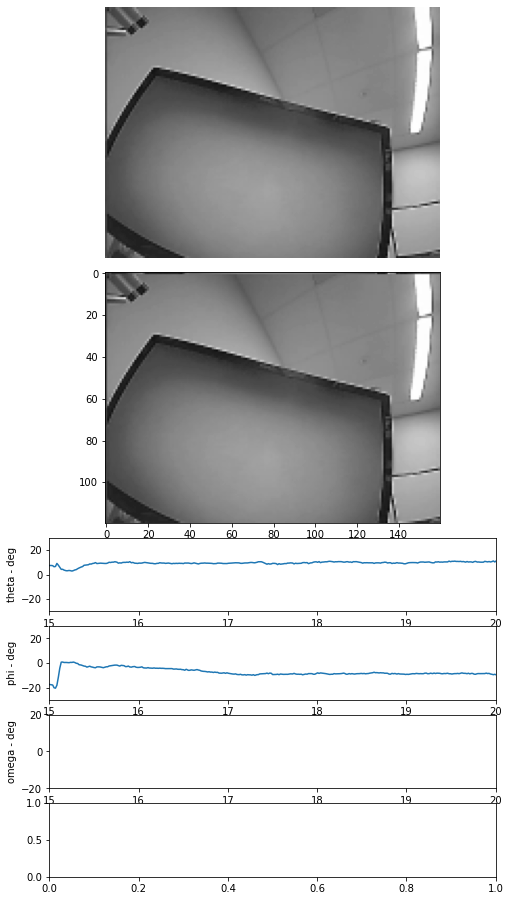

In [38]:
# eye correction movie

tr = [15,20]
fig = plt.figure(figsize = (8,16))
gs = fig.add_gridspec(10,1)
#axEye = fig.add_subplot(gs[0,0])
axWorld = fig.add_subplot(gs[0:3,:])
axWorldFix = fig.add_subplot(gs[3:6,:])

axTheta = fig.add_subplot(gs[6,:])
axPhi = fig.add_subplot(gs[7,:])
axOmega = fig.add_subplot(gs[8,:])
axGyro = fig.add_subplot(gs[9,:])

th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

axTheta.plot(eyeT,th)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

axPhi.plot(eyeT,phi)
axPhi.set_xlim(tr[0],tr[1]); 
axPhi.set_ylabel('phi - deg'); axPhi.set_ylim(-30,30)

#axOmega.plot(eyeT,omega)
axOmega.set_xlim(tr[0],tr[1]); 
axOmega.set_ylabel('omega - deg'); axOmega.set_ylim(-20,20)

if free_move & has_imu:
    axGyro.plot(accT,gz)
    axGyro.set_xlim(tr[0],tr[1]); 
    axGyro.set_ylabel('gyro - deg'); axGyro.set_ylim(1,4)

thInterp =interp1d(eyeT,th)
phiInterp =interp1d(eyeT,phi)
pix_per_deg = 1.6;

vidfile = name_base + '_corrected_' + str(this_unit) + '.mp4'
# now animate
writer = FFMpegWriter(fps=30)
with writer.saving(fig, vidfile, 100):
#    for t in np.arange(tr[0],tr[1],1/30):
    for t in tqdm(worldT[(worldT>tr[0]) & (worldT<tr[1])]):        
        # show eye and world frames
        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        #axEye.set_xlim(0,160); axEye.set_ylim(0,120)
        
        world = worldInterp(t)
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(world,'gray',vmin=0,vmax=255,aspect = "equal")
        
        worldFix= np.roll(world,(-np.int8(thInterp(t)*ymap[0] + phiInterp(t)*ymap[1]),-np.int8(thInterp(t)*xmap[0] + phiInterp(t)*xmap[1])),axis = (0,1))
        axWorldFix.imshow(worldFix,'gray',vmin=0, vmax = 255, aspect = 'equal')
        
        #plot line for time, then remove
        ln1 = axTheta.vlines(t,-0.5,30,'b')
        ln2 = axPhi.vlines(t,-0.5,30,'b')
        writer.grab_frame()
        ln1.remove()
        ln2.remove()


In [39]:
ymap

[-0.076365844, 0.083263225]

In [40]:
max_frames = 60*60

thInterp =interp1d(eyeT,th, bounds_error = False, fill_value = 0)
phiInterp =interp1d(eyeT,phi, bounds_error = False, fill_value = 0)

world_fix = np.zeros((max_frames, np.size(world_vid,1), np.size(world_vid,2)),'uint8')
for f in tqdm(range(max_frames)):
    t = worldT[f]
    thInt = thInterp(t)
    if np.isnan(thInt):
        thInt =0
    phiInt = phiInterp(t) 
    if np.isnan(phiInt):
        phiInt =0
               
    world_fix[f,:,:]= imshift(world_vid[f,:,:],(-(thInt*ymap[0] + phiInt*ymap[1]),-(thInt*xmap[0] + phiInt*xmap[1])))

number_of_iterations = 5000;
termination_eps = 1e-4;
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
warp_mode = cv2.MOTION_TRANSLATION
cc_fix = np.zeros(max_frames); xshift_fix = np.zeros(max_frames); yshift_fix = np.zeros(max_frames);
for i in tqdm(range(max_frames-1)):
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    (cc_fix[i], warp_matrix) = cv2.findTransformECC (world_fix[i,:,:],world_fix[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
    xshift_fix[i] = warp_matrix[0,2]; yshift_fix[i] = warp_matrix[1,2]


    

100%|██████████████████████████████████████████████████████████████████████████████| 3599/3599 [00:58<00:00, 61.87it/s]


In [41]:
if free_move:
    plt.figure(figsize = (16,8))
    plt.subplot(2,1,1)
    plt.plot(xshift,label = 'x pre alignment')
    plt.plot(xshift_fix,label = 'x post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

    plt.subplot(2,1,2)
    plt.plot(yshift,label = 'y pre alignment')
    plt.plot(yshift_fix, label = 'y post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

100%|██████████████████████████████████████████████████████████████████████████████| 3599/3599 [08:02<00:00,  7.46it/s]


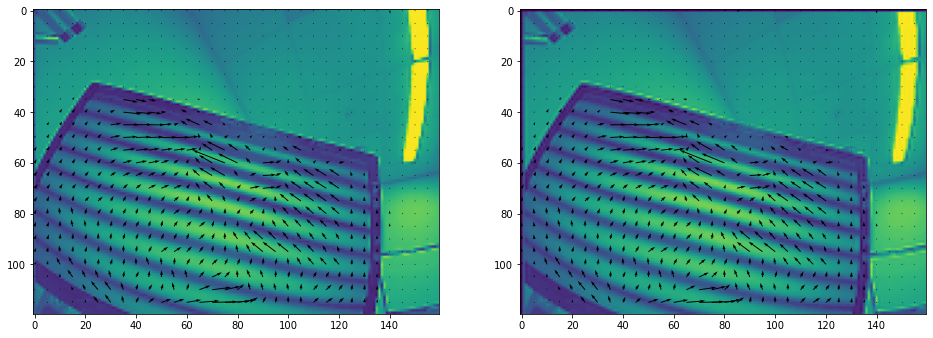

In [42]:
max_frame = 60*60
flow = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
flow_fix = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
x,y = np.meshgrid(np.arange(0, np.size(world_vid,2)), np.arange(0,np.size(world_vid,1)))
vidfile = name_base + '_flowfix.mp4'

fig, axs = plt.subplots(1,2,figsize = (16,8))
# now animate
writer = FFMpegWriter(fps=30)
nx = 5;
with writer.saving(fig, vidfile, 100):
    for f in tqdm(range(max_frame-1)):

        flow[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_vid[f,:,:],world_vid[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[0].cla()
        axs[0].imshow(world_vid[f,:,:],vmin = 0, vmax = 255)
        u = flow[f,:,:,0]; v = flow[f,:,:,1]
        axs[0].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )
        
        flow_fix[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_fix[f,:,:],world_fix[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[1].cla()
        axs[1].imshow(world_fix[f,:,:],vmin = 0, vmax = 255)
        u = flow_fix[f,:,:,0]; v = flow[f,:,:,1]
        axs[1].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )
        
        writer.grab_frame()

In [43]:
dEye = np.diff(th)
if free_move & has_imu:
    gInterp = interp1d(accT,(gz-np.nanmean(gz))*7.5 , bounds_error = False)
    plt.figure(figsize = (8,4))
    plt.subplot(1,2,1)
    plt.plot(eyeT[0:-1],dEye, label = 'dEye')
    plt.plot(eyeT, gInterp(eyeT), label = 'dHead')
    #plt.plot(accT-0.11,(gz-np.nanmean(gz))*7 )
    #plt.plot(eyeT[0:-1],gInterp(eyeT[0:-1])-dEye, label = 'dgaze')
    plt.xlim(37,39); plt.ylim(-10,10); plt.legend(); plt.ylabel('deg'); plt.xlabel('secs')
    plt.subplot(1,2,2)
    plt.plot(eyeT[0:-1],np.nancumsum(gInterp(eyeT[0:-1])), label = 'head')
    plt.plot(eyeT[0:-1],np.nancumsum(gInterp(eyeT[0:-1])-dEye),label ='gaze')
    plt.plot(eyeT[1:],th[0:-1],label ='eye')
    plt.xlim(35,40); plt.ylim(-30,30); plt.legend(); plt.ylabel('deg'); plt.xlabel('secs')
    plt.tight_layout()

Text(0.5, 1.0, 'mean of image')

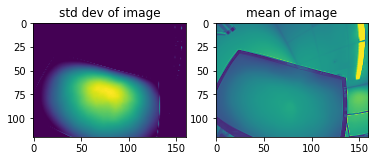

In [44]:
plt.subplot(1,2,1)
plt.imshow(std_im)
plt.title('std dev of image')
plt.subplot(1,2,2)
plt.imshow(np.mean(world_vid,axis=0),vmin=0,vmax=255)
plt.title('mean of image')

Text(0, 0.5, 'contrast')

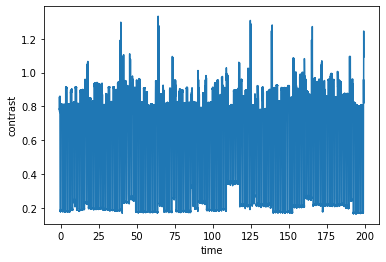

In [45]:
#calculate image contrast
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:12000],contrast[0:12000])
plt.xlabel('time')
plt.ylabel('contrast')


In [46]:
#set up timebase for subsequent analysis
dt = 0.025
t = np.arange(0, np.max(worldT),dt)

Text(0, 0.5, 'contrast')

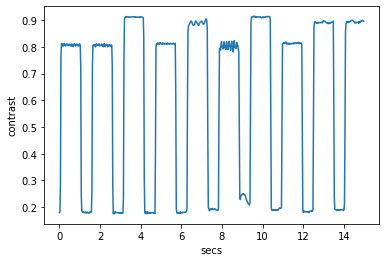

In [47]:
# interpolate and plot contrast
newc =interp1d(worldT,contrast)
contrast_interp = newc(t[0:-1])
contrast_interp.shape
plt.plot(t[0:600],contrast_interp[0:600])
plt.xlabel('secs'); plt.ylabel('contrast')

In [48]:
# calculate firing rate at new timebase
ephys_data['rate'] = nan
ephys_data['rate'] = ephys_data['rate'].astype(object)
for i,ind in enumerate(ephys_data.index):
    ephys_data.at[ind,'rate'],bins = np.histogram(ephys_data.at[ind,'spikeT'],t)
ephys_data['rate']= ephys_data['rate']/dt
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells

Amplitude  ContamPct KSLabel         amp  ch  depth         fr group  \
14      1560.7       38.0     mua   76.501175  13    326   3.180178  good   
19      1108.6       19.5     mua   63.576565  15    376   5.009118  good   
20      1054.0        4.9    good   84.590919  15    376   4.459088  good   
38       893.4       15.0     mua   64.314270  19    476   4.648459  good   
45      1052.8       17.0     mua   75.534012  21    526   4.429170  good   
60      1478.9        6.7    good   67.629257  25    626   9.382069  good   
114     1383.5        1.0    good   90.567123  49    426  38.279181  good   
130      895.0        8.1    good   74.902039  53    526   7.155977  good   
145     1033.0       15.7     mua   71.115013  56    601   4.969994  good   
146     1549.5        4.0    good   71.425850  56    601   9.574398  good   
147     1084.1       28.9     mua   70.156807  56    601   1.953214  good   
169     2013.2        1.1    good   77.952667  59    676   3.651632  good   
171     2094.8        0.9    good   84.574234  60    701  13.730690  good   
176     1219.7       26.6     mua   84.476120  62    751   5.042981  good   
182     2688.9        2.2    good  100.890335  11    276   1.883186  good   
190      655.0        4.5    good   62.955040  30    751   8.311269  good   
191      897.4        0.0    good   77.605743  30    751   3.900510  good   
192      688.9        5.0    good   66.857857  30    751   8.853080  good   
196      782.6        9.2    good   52.905666  55    576   3.085164  good   

     n_spikes  sh                                           waveform  \
14       9673   0  [0.0318300724, 0.0303256121, 0.0319133699, 0.0...   
19      15236   0  [0.035081155600000004, 0.0336350799, 0.0354663...   
20      13563   0  [0.0467762202, 0.0439777412, 0.047026954600000...   
38      14139   0  [0.0441444665, 0.0427553654, 0.0452394299, 0.0...   
45      13472   0  [0.0477663875, 0.046341244100000005, 0.0492711...   
60      28537   0  [0.0345240906, 0.033132337000000005, 0.0354509...   
114    116432   0  [0.0066352603, 0.0042942865, 0.004391727000000...   
130     21766   0  [0.0034959845000000003, 0.0216697175, 0.017325...   
145     15117   0  [0.0232956819, 0.0440238118, 0.0420005284, 0.0...   
146     29122   0  [0.02075224, 0.0375546515, 0.0357617177, 0.038...   
147      5941   0  [0.0206955615, 0.0410341211, 0.0389023498, 0.0...   
169     11107   0  [0.029353983700000003, 0.0529063195, 0.0500591...   
171     41764   0  [0.0293627102, 0.0568467677, 0.0535510778, 0.0...   
176     15339   0  [0.0435366929, 0.0402510725, 0.042500693400000...   
182      5728   0  [0.026162575900000002, 0.0245640539, 0.0251186...   
190     25280   0  [0.0007222605, 0.014988436400000001, 0.0379020...   
191     11864   0  [0.0160002224, 0.0427428558, 0.0385617502, 0.0...   
192     26928   0  [0.0134335626, 0.0363573655, 0.0327467434, 0.0...   
196      9384   0  [0.0258760825, 0.0441119112, 0.042339727300000...   

                                                spikeT            t0  \
14   [0.16427357000000004, 0.72511748, 1.0974802399...  40991.239782   
19   [0.015288469999999998, 0.02685398003332999, 0....  40991.239782   
20   [0.11924474003333, 0.29889343996667, 0.5433023...  40991.239782   
38   [-0.09273405996667, -0.06966970003333, -0.0092...  40991.239782   
45   [0.35668765996667007, 0.7178515399666701, 0.97...  40991.239782   
60   [-0.07226944003333001, -0.028007199999999996, ...  40991.239782   
114  [-0.08646802003333, -0.06377029003333, -0.0466...  40991.239782   
130  [-0.05083824996667001, -0.043872280033330005, ...  40991.239782   
145  [0.31265873, 0.44567875996667006, 0.9387294499...  40991.239782   
146  [-0.0028763800333300032, 0.11684498003333, 0.2...  40991.239782   
147  [0.4536446300000001, 0.5798320100000001, 0.680...  40991.239782   
169  [2.21446853, 6.74841509, 13.18283825003333, 17...  40991.239782   
171  [-0.03897277003333, -0.0047095299999999896, 0....  40991.239782   
176  [0.0846815

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'sp/sec')

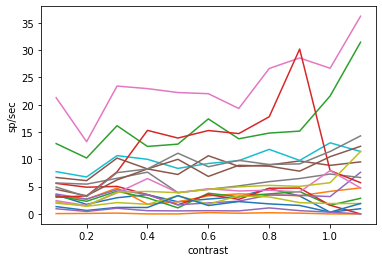

In [49]:
# calculate contrast - response functions
# mean firing rate in timebins correponding to contrast ranges
resp = np.empty((n_units,12))
crange = np.arange(0,1.2,0.1)
for i,ind in enumerate(goodcells.index):
    for c,cont in enumerate(crange):
        resp[i,c] = np.mean(goodcells.at[ind,'rate'][(contrast_interp>cont) & (contrast_interp<(cont+0.1))])
plt.plot(crange,np.transpose(resp))
#plt.ylim(0,10)
plt.xlabel('contrast')
plt.ylabel('sp/sec')
    

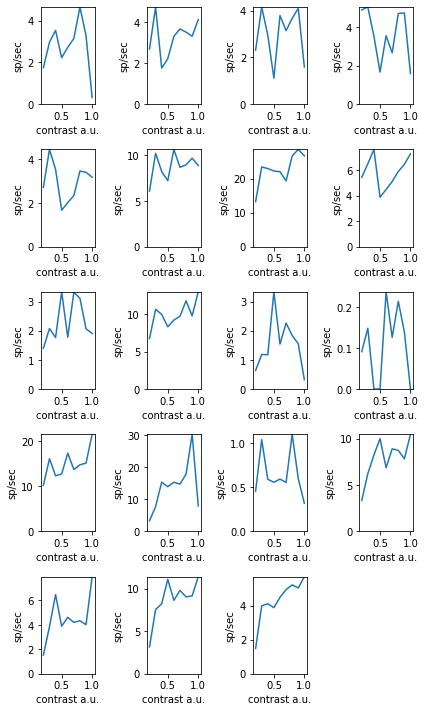

In [50]:
# plot individual contrast response functions in subplots
fig = plt.figure(figsize = (6,np.ceil(n_units/2)))
for i, ind in enumerate(goodcells.index):
    plt.subplot(np.ceil(n_units/4),4,i+1)
    plt.plot(crange[2:-1],resp[i,2:-1])
   # plt.ylim([0 , max(resp[i,1:-3])*1.2])
    plt.xlabel('contrast a.u.'); plt.ylabel('sp/sec'); plt.ylim([0,np.nanmax(resp[i,2:-1])])
plt.tight_layout()
plt.savefig(name_base + '_contrast.pdf')

In [51]:
# create interpolator for movie data so we can evaluate at same timebins are firing rat
img_norm[img_norm<-2] = -2
movInterp = interp1d(worldT,img_norm,axis=0)

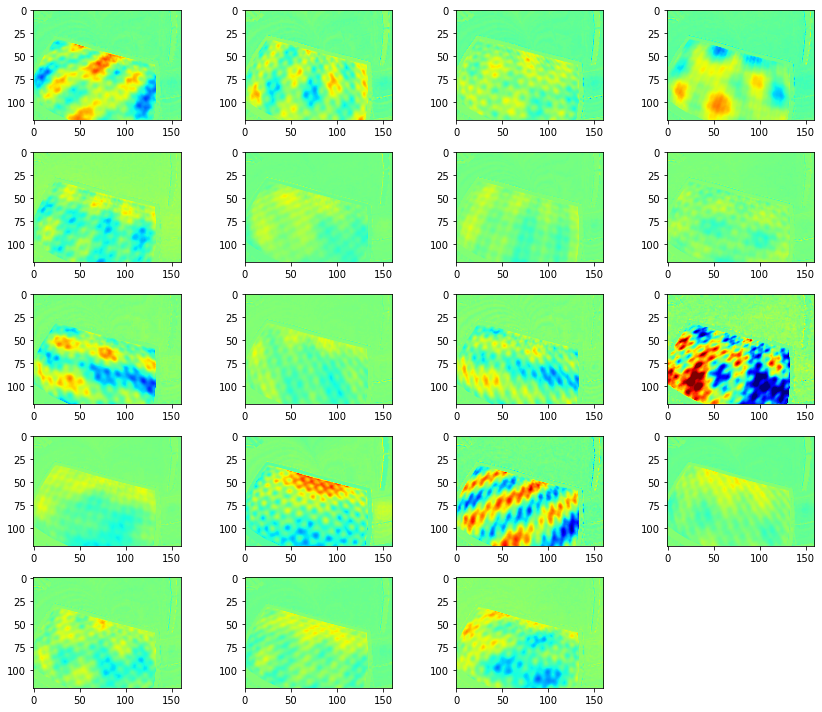

In [52]:
# calculate spike-triggered average
#spike_corr = 1 + 0.125/1200  # correction factor for ephys timing drift

staAll = np.zeros((n_units,np.shape(img_norm)[1],np.shape(img_norm)[2]))
lag = 0.125;
plt.figure(figsize = (12,np.ceil(n_units/2)))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    sta = 0; nsp = 0
    sp = goodcells.at[ind,'spikeT'].copy()
    if c==1:
        ensemble = np.zeros((len(sp),np.shape(img_norm)[1],np.shape(img_norm)[2]))
    for s in sp:
        if (s-lag >5) & ((s-lag) <np.max(worldT)):
            nsp = nsp+1
            im = movInterp(s-lag);
            if c==1:
                ensemble[nsp-1,:,:] = im
            sta = sta+im;
    plt.subplot(np.ceil(n_units/4),4,c+1)
    sta = sta/nsp
    #sta[abs(sta)<0.1]=0
    plt.imshow((sta-np.mean(sta) ),vmin=-0.3,vmax=0.3,cmap = 'jet')
    staAll[c,:,:] = sta;
plt.tight_layout()
plt.savefig(name_base + '_sta.pdf')


100%|███████████████████████████████████████████████████████████████████████████| 19374/19374 [01:54<00:00, 169.84it/s]


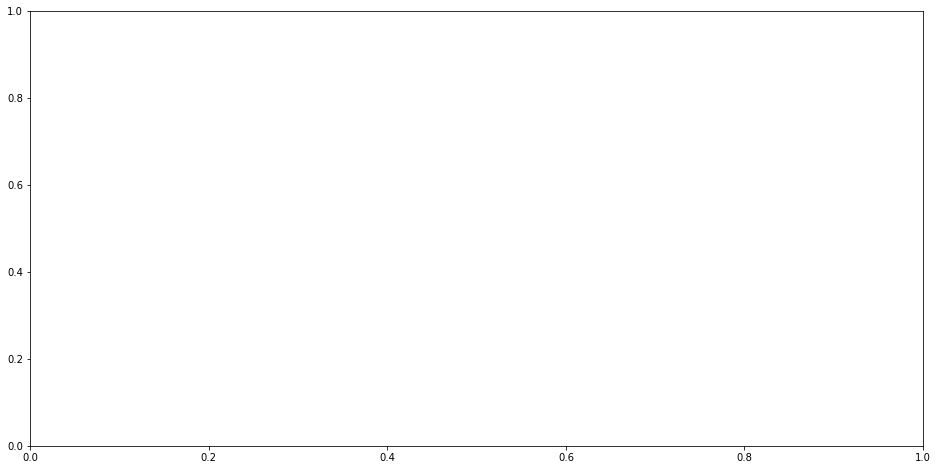

In [393]:
nf = np.size(img_norm,0)-1;
#nf = 120
u_mn = np.zeros((nf,1)); v_mn = np.zeros((nf,1))
sx_mn = np.zeros((nf,1)) ; sy_mn = np.zeros((nf,1))
flow_norm = np.zeros((nf,np.size(img_norm,1),np.size(img_norm,2),2 ))
vidfile = name_base + '_grating_flow.mp4'

fig, ax = plt.subplots(1,1,figsize = (16,8))
# now animate
#writer = FFMpegWriter(fps=30)
#with writer.saving(fig, vidfile, 100):
for f in tqdm(range(nf)):
    frm = np.uint8(32*(img_norm[f,:,:]+4))
    frm2 = np.uint8(32*(img_norm[f+1,:,:]+4))
    flow_norm[f,:,:,:] = cv2.calcOpticalFlowFarneback(frm,frm2, None, 0.5, 3, 30, 3, 7, 1.5, 0)
    #ax.cla()
    #ax.imshow(frm,vmin = 0, vmax = 255)
    u = flow_norm[f,:,:,0]; v = -flow_norm[f,:,:,1]  # negative to fix sign for y axis in images
    sx = cv2.Sobel(frm,cv2.CV_64F,1,0,ksize=7)
    sy = -cv2.Sobel(frm,cv2.CV_64F,0,1,ksize=7)# negative to fix sign for y axis in images
    sx[std_im<0.05]=0; sy[std_im<0.05]=0; # get rid of values outside of monitor
    sy[sx<0] = -sy[sx<0]  #make vectors point in positive x direction (so opposite sides of grating don't cancel)
    sx[sx<0] = -sx[sx<0]
    #ax.quiver(x[::nx,::nx],y[::nx,::nx],sx[::nx,::nx],sy[::nx,::nx], scale = 100000 )
    u_mn[f]= np.mean(u); v_mn[f]= np.mean(v); sx_mn[f] = np.mean(sx); sy_mn[f] = np.mean(sy)
    #plt.title(str(np.round(np.arctan2(sy_mn[f],sx_mn[f])*180/np.pi))
    #writer.grab_frame()



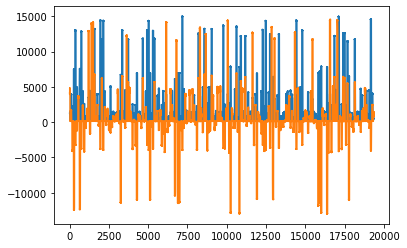

In [394]:
plt.plot(sx_mn)
plt.plot(sy_mn)

(array([ 120., 1576.,  446.,  335.,  123.,  105.,   95.,   54.,  134.,
         231.,  102.,  267., 1308.,  640.,  377.,  182.,   33.,   36.,
         306.,  220.,   35.,   77.,  892., 3024., 3764., 1440.,  208.,
         155.,   17.,   45.,   47.,  117.,  236.,  290.,  228., 2109.]),
 array([-65.16762672, -61.27635835, -57.38508999, -53.49382162,
        -49.60255325, -45.71128488, -41.82001651, -37.92874814,
        -34.03747977, -30.1462114 , -26.25494303, -22.36367466,
        -18.47240629, -14.58113792, -10.68986955,  -6.79860118,
         -2.90733281,   0.98393556,   4.87520393,   8.7664723 ,
         12.65774067,  16.54900904,  20.44027741,  24.33154578,
         28.22281415,  32.11408252,  36.00535089,  39.89661925,
         43.78788762,  47.67915599,  51.57042436,  55.46169273,
         59.3529611 ,  63.24422947,  67.13549784,  71.02676621,
         74.91803458]),
 <a list of 36 Patch objects>)

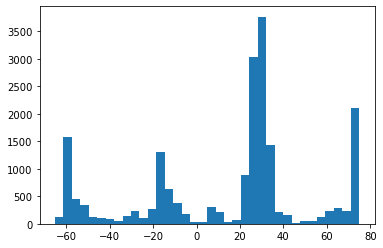

In [395]:
#plt.plot(np.arctan2(sy_mn,sx_mn)*180/np.pi)
plt.hist(np.arctan2(sy_mn,sx_mn)*180/np.pi,36)

(0.0, 120.0)

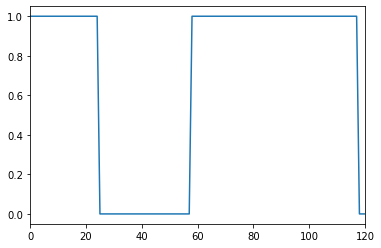

In [145]:
stimOn = contrast>0.5;
stimOn = signal.medfilt(stimOn,11)
plt.plot(stimOn); plt.xlim(0,120)

1282.5900323935816
4636.627920346205
13844.746953688289
[2. 0. 0. 5. 5. 3. 4. 1. 6. 0. 4. 7. 7. 1. 3. 7. 6. 3. 6. 5. 5. 6. 1. 2.
 1. 7. 0. 1. 1. 6. 2. 6. 3. 5. 0. 2. 6. 5. 3. 2. 7. 3. 4. 2. 4. 4. 6. 6.
 4. 6. 2. 2. 5. 1. 4. 1. 1. 2. 3. 2. 5. 7. 4. 1. 0. 7. 0. 5. 3. 6. 2. 0.
 7. 0. 4. 0. 5. 5. 3. 5. 3. 7. 6. 7. 6. 1. 0. 2. 3. 7. 1. 6. 3. 4. 1. 5.
 2. 3. 0. 1. 7. 6. 7. 2. 5. 4. 7. 3. 0. 4. 7. 4. 5. 6. 0. 0. 2. 3. 6. 6.
 5. 2. 6. 5. 7. 4. 6. 4. 3. 3. 1. 5. 0. 1. 2. 6. 1. 7. 0. 3. 1. 2. 1. 0.
 5. 1. 6. 6. 2. 3. 5. 2. 0. 7. 5. 7. 1. 5. 5. 2. 7. 3. 1. 6. 3. 3. 5. 2.
 4. 0. 4. 4. 7. 1. 6. 0. 0. 7. 0. 7. 6. 6. 3. 1. 3. 4. 6. 2. 4. 2. 0. 6.
 1. 0. 2. 2. 6. 1. 1. 2. 7. 7. 6. 2. 5. 1. 6.]


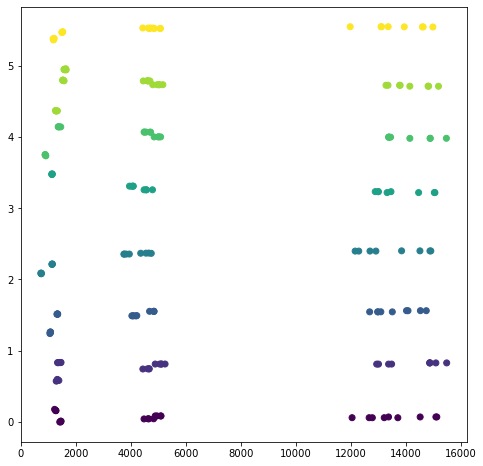

In [399]:
stim_start = np.array(worldT[np.where(np.diff(stimOn)>0)])
stim_end = np.array(worldT[np.where(np.diff(stimOn)<0)])
stim_end = stim_end[stim_end>stim_start[0]]
stim_start = stim_start[stim_start<stim_end[-1]]
grating_th = np.zeros(len(stim_start))
grating_mag = np.zeros(len(stim_start))
grating_dir = np.zeros(len(stim_start))
for i in range(len(stim_start)):
    stim_u = np.median(u_mn[np.where((worldT>stim_start[i] + 0.025) & (worldT<stim_end[i]-0.025))])
    stim_v = np.median(v_mn[np.where((worldT>stim_start[i] + 0.025) & (worldT<stim_end[i]-0.025))])
    stim_sx = np.median(sx_mn[np.where((worldT>stim_start[i] + 0.025) & (worldT<stim_end[i]-0.025))])
    stim_sy = np.median(sy_mn[np.where((worldT>stim_start[i] + 0.025) & (worldT<stim_end[i]-0.025))])
    grating_th[i] = np.arctan2(stim_sy,stim_sx)
    grating_mag[i] = np.sqrt(stim_sx**2 + stim_sy**2)
    grating_dir[i] = np.sign(stim_u*stim_sx + stim_v*stim_sy) # dot product of gratient and flow gives direction
#grating_th = np.round(grating_th *10)/10

grating_ori = grating_th.copy()
grating_ori[grating_dir<0] = grating_ori[grating_dir<0] + np.pi
grating_ori = grating_ori - np.min(grating_ori)
np.unique(grating_ori)
plt.figure(figsize = (8,8))

ori_cat = np.floor((grating_ori+np.pi/8)/(np.pi/4))


km = KMeans(n_clusters=3).fit(np.reshape(grating_mag,(-1,1)))
sf_cat = km.labels_
order = np.argsort(np.reshape(km.cluster_centers_, 3))
sf_catnew = sf_cat.copy()
for i in range(3):
    sf_catnew[sf_cat == order[i]]=i
sf_cat = sf_catnew.copy()
plt.scatter(grating_mag,grating_ori,c=ori_cat)
print(np.mean(grating_mag[sf_cat ==0]))
print(np.mean(grating_mag[sf_cat ==1]))
print(np.mean(grating_mag[sf_cat ==2]))
print(ori_cat)


array([ 2.5702698 ,  2.87857551,  2.79818619,  5.21874492,  3.2554087 ,
        6.5131507 , 16.72802311,  5.56096119,  1.78380737,  7.24115691,
        0.97312624,  0.07274036, 11.51590333,  3.13540547,  0.69597331,
        3.74974422,  1.91595571,  3.98502179,  1.75764451])

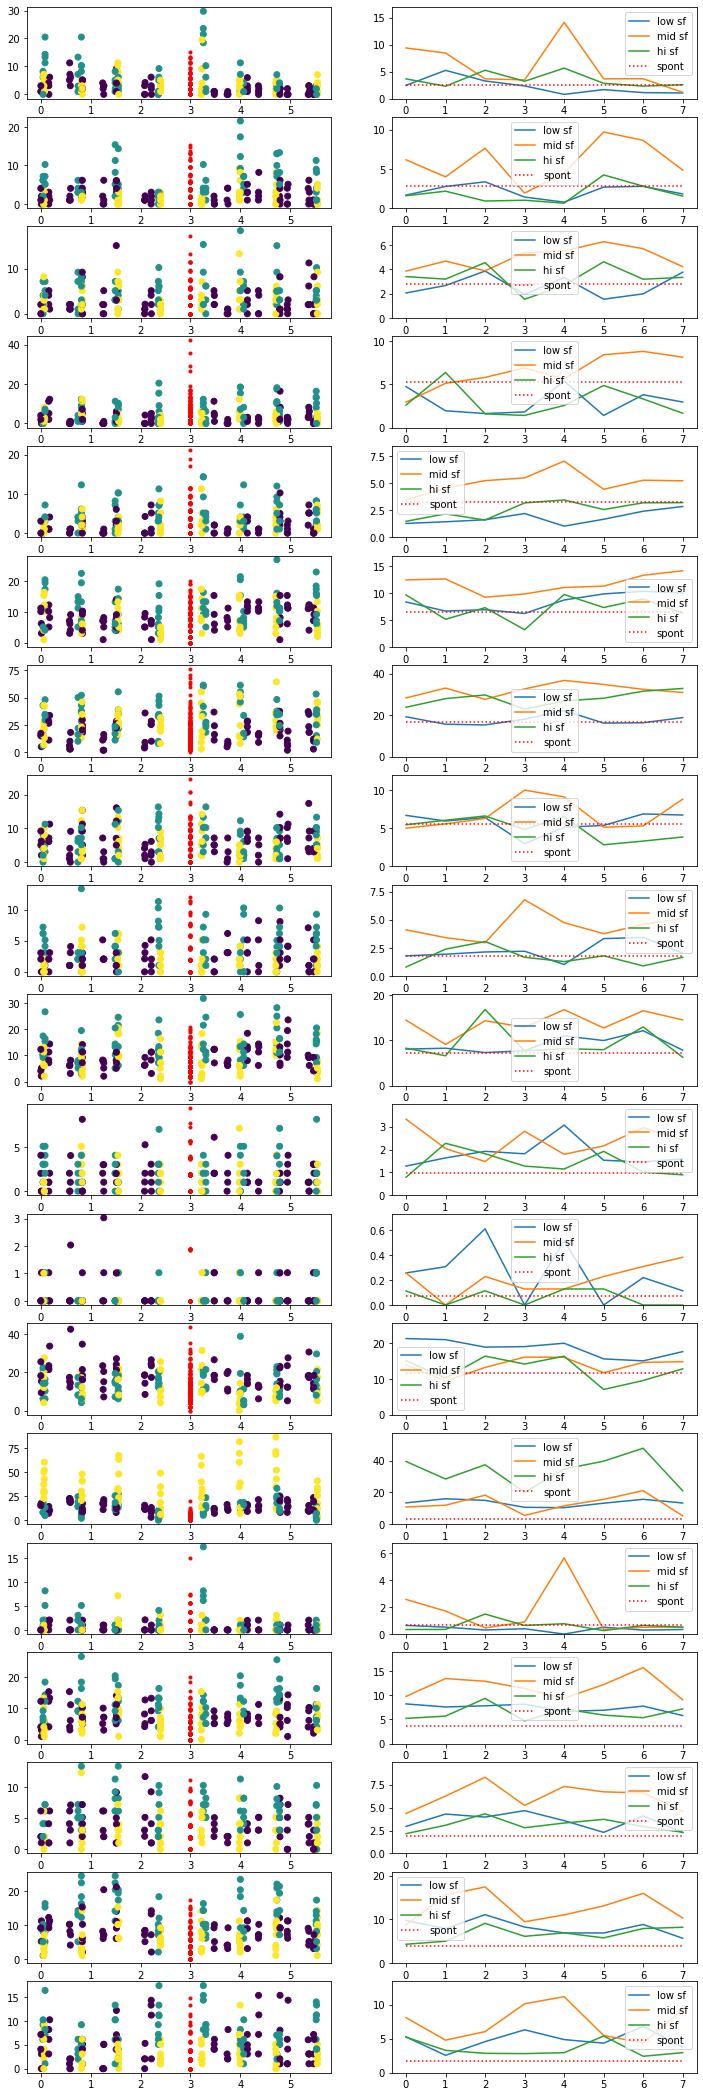

In [401]:
edge_win = 0.025;
grating_rate = np.zeros((len(goodcells),len(stim_start)))
spont_rate = np.zeros((len(goodcells),len(stim_start)))
ori_tuning = np.zeros((len(goodcells),8,3))
drift_spont = np.zeros(len(goodcells))
plt.figure(figsize = (12,n_units*2))

for c, ind in enumerate(goodcells.index):
    sp = goodcells.at[ind,'spikeT'].copy()
    for i in range(len(stim_start)):
        grating_rate[c,i] = np.sum((sp> stim_start[i]+edge_win) & (sp<stim_end[i])) / (stim_end[i] - stim_start[i]- edge_win)
    for i in range(len(stim_start)-1):
        spont_rate[c,i] = np.sum((sp> stim_end[i]+edge_win) & (sp<stim_start[i+1])) / (stim_start[i+1] - stim_end[i]- edge_win)  
    for ori in range(8):
        for sf in range(3):
            ori_tuning[c,ori,sf] = np.mean(grating_rate[c,(ori_cat==ori) & (sf_cat ==sf)])
    drift_spont[c] = np.mean(spont_rate[c,:])
    plt.subplot(n_units,2,2*c+1)
    plt.scatter(grating_ori,grating_rate[c,:],c= sf_cat)
    plt.plot(3*np.ones(len(spont_rate[c,:])),spont_rate[c,:],'r.')
    plt.subplot(n_units,2,2*c+2)
    plt.plot(ori_tuning[c,:,0],label = 'low sf'); plt.plot(ori_tuning[c,:,1],label = 'mid sf');plt.plot(ori_tuning[c,:,2],label = 'hi sf');
    plt.plot([0,7],[drift_spont[c],drift_spont[c]],'r:', label = 'spont')
    plt.legend()
    plt.ylim(0,np.nanmax(ori_tuning[c,:,:]*1.2))
drift_spont


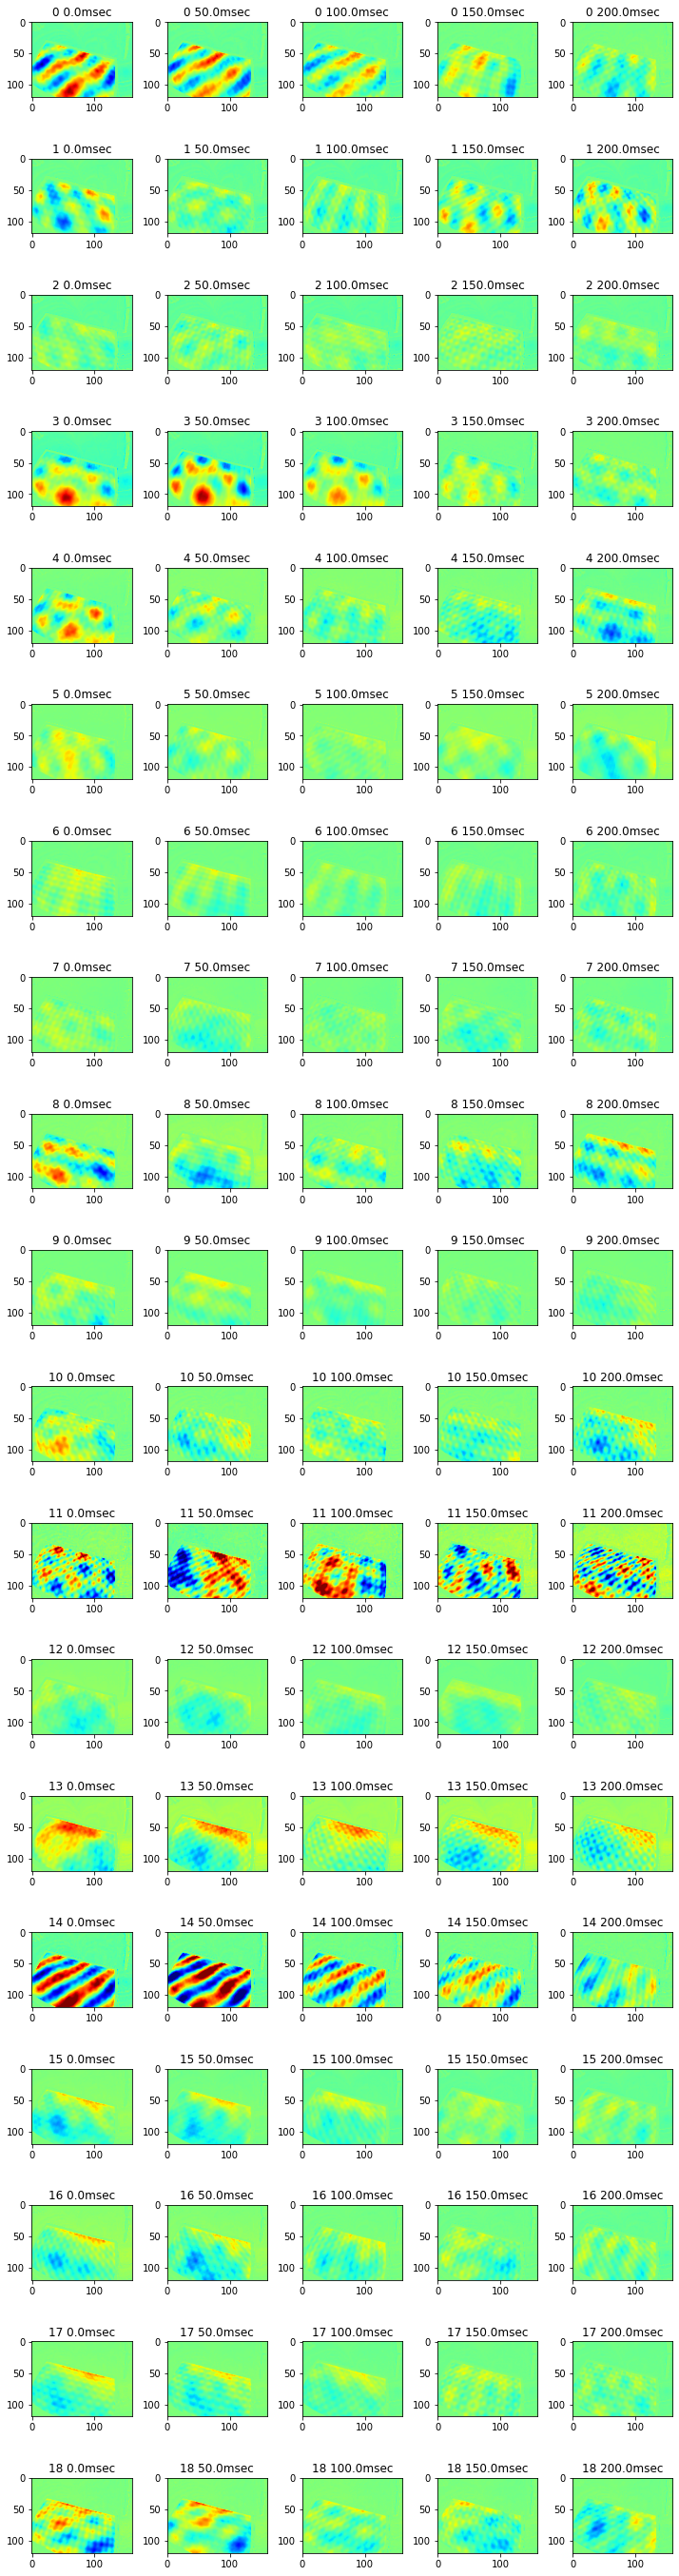

In [54]:
# calculate spike-triggered average
spike_corr = 1 + 0.125/1200
sta = 0
lag = 0.075
lagRange = np.arange(0,0.25,0.05)
plt.figure(figsize = (12,2*n_units))
for c, ind in enumerate(goodcells.index):
    sp = goodcells.at[ind,'spikeT'].copy()
    for  lagInd, lag in enumerate(lagRange):
        sta = 0; nsp = 0
        for s in sp:
            if (s-lag >5) & ((s-lag) <np.max(worldT)):
                nsp = nsp+1
                sta = sta+movInterp(s-lag)
        plt.subplot(n_units,6,(c*6)+lagInd + 1)
        sta = sta/nsp
    #sta[abs(sta)<0.1]=0
        plt.imshow(sta ,vmin=-0.35,vmax=0.35,cmap = 'jet')
        plt.title(str(c) + ' ' + str(np.round(lag*1000)) + 'msec')
plt.tight_layout()
plt.savefig(name_base +'_staLag.pdf')

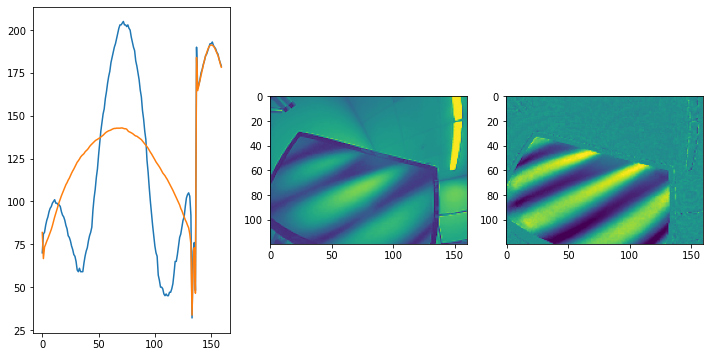

In [217]:
# some testing of video
thisT = 200
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
plt.plot(world_vid[thisT,75,:])
plt.plot(np.mean(world_vid[:,75,:],axis=0))
plt.subplot(1,3,2)
plt.imshow(world_vid[thisT,:,:],vmin=0,vmax=255)
plt.subplot(1,3,3)
plt.imshow(img_norm[thisT,:,:],vmin=-2,vmax=2)

Text(0.5, 0, 'pixel intensity')

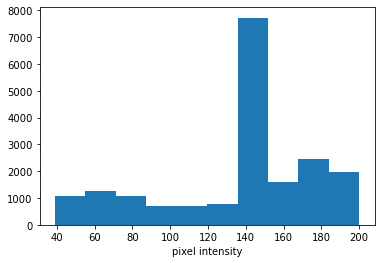

In [57]:
plt.hist(world_vid[:,75,50])
plt.xlabel('pixel intensity')

(0.0, 60.0)

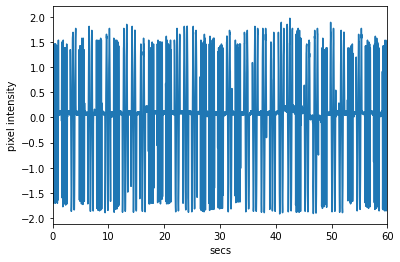

In [58]:
plt.plot(worldT,img_norm[:,75,50])
plt.xlabel('secs'); plt.ylabel('pixel intensity')
plt.xlim(0,60)

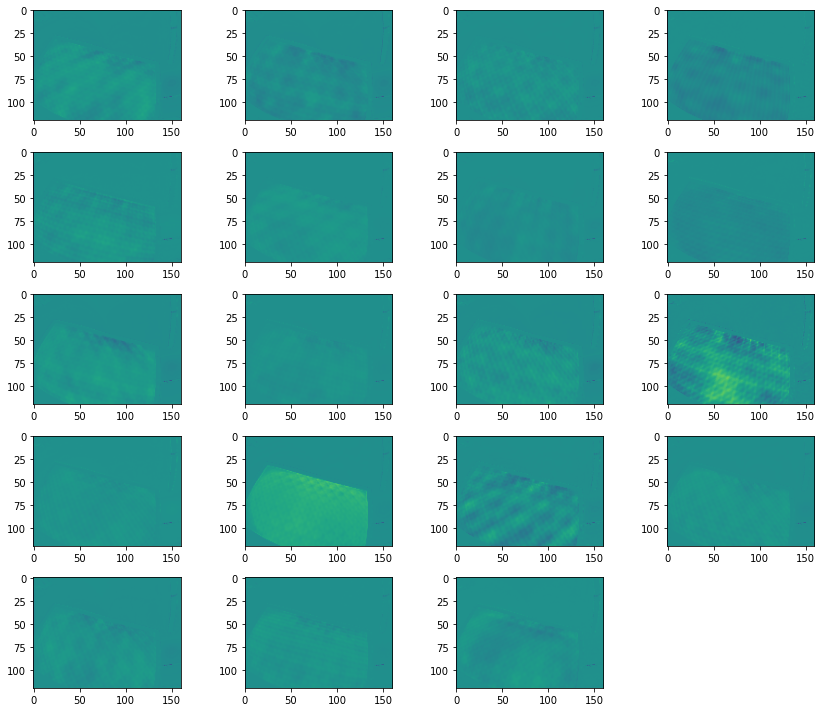

In [59]:
# calculate spike-triggered variance
sta = 0
lag = 0.125
plt.figure(figsize = (12,np.ceil(n_units/2)))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    sta = 0
    for i in range(5,t.size-10):
        sta = sta+r[i]*(movInterp(t[i]-lag))**2
    plt.subplot(np.ceil(n_units/4),4,c+1)
    sta = sta/np.sum(r)
    plt.imshow(sta - np.mean(img_norm**2,axis=0),vmin=-1,vmax=1)
plt.tight_layout()

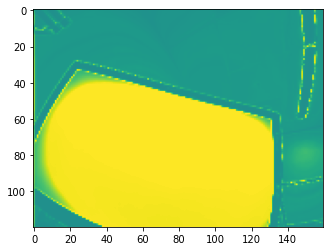

In [60]:
plt.imshow(np.mean(img_norm**2,axis=0),vmin=-1,vmax=1)

<ipython-input-61-a47ea37c3e68>:9: RuntimeWarning: invalid value encountered in greater
  upsacc = eyeT[np.append(dEye,0)>sthresh]
<ipython-input-61-a47ea37c3e68>:12: RuntimeWarning: invalid value encountered in less
  downsacc= eyeT[np.append(dEye,0)<-sthresh]


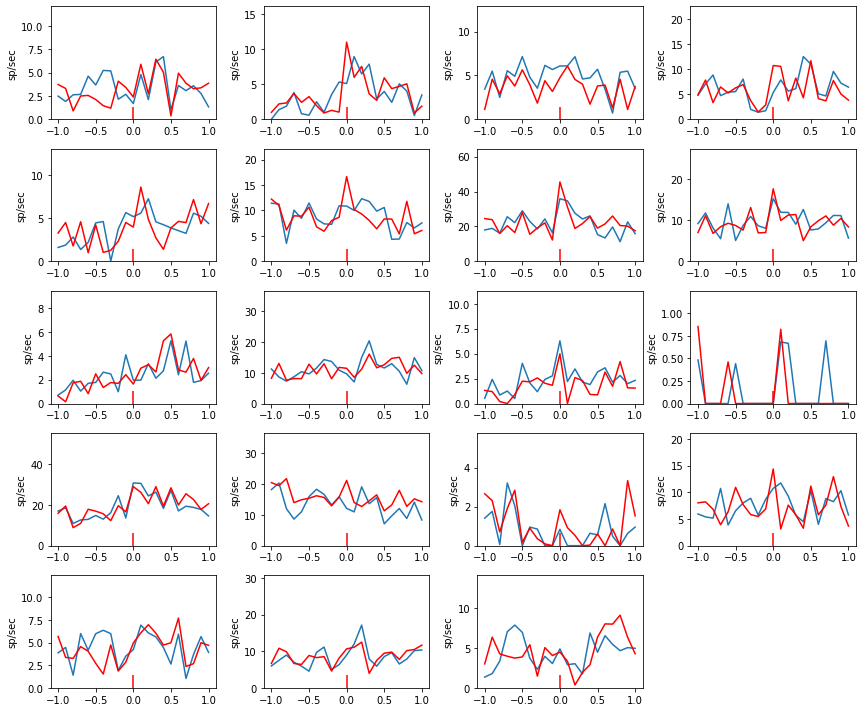

In [61]:
# calculate saccade-locked psth

#spike_corr = 1 + 0.125/1200  # correction factor for ephys timing drift
dEye= np.diff(th_switch)

fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
trange = np.arange(-1,1.1,0.1)
sthresh = 8;
upsacc = eyeT[np.append(dEye,0)>sthresh]
upsacc = upsacc[upsacc>5]
upsacc = upsacc[upsacc<np.max(t)-5]
downsacc= eyeT[np.append(dEye,0)<-sthresh]
downsacc = downsacc[downsacc>5]
downsacc = downsacc[downsacc<np.max(t)-5]
upsacc_avg = np.zeros((units.size,trange.size))
downsacc_avg = np.zeros((units.size,trange.size))
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    for s in upsacc:
        upsacc_avg[i,:] = upsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/upsacc.size
    for s in downsacc:
        downsacc_avg[i,:]= downsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/downsacc.size
    plt.subplot(np.ceil(n_units/4),4,i+1)
    plt.plot(trange,upsacc_avg[i,:])
    plt.plot(trange,downsacc_avg[i,:],'r')
    plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2),'r')
    plt.ylim([0, np.max(upsacc_avg[i,:])*1.8])
    plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig(name_base + '_saccade.pdf')
        


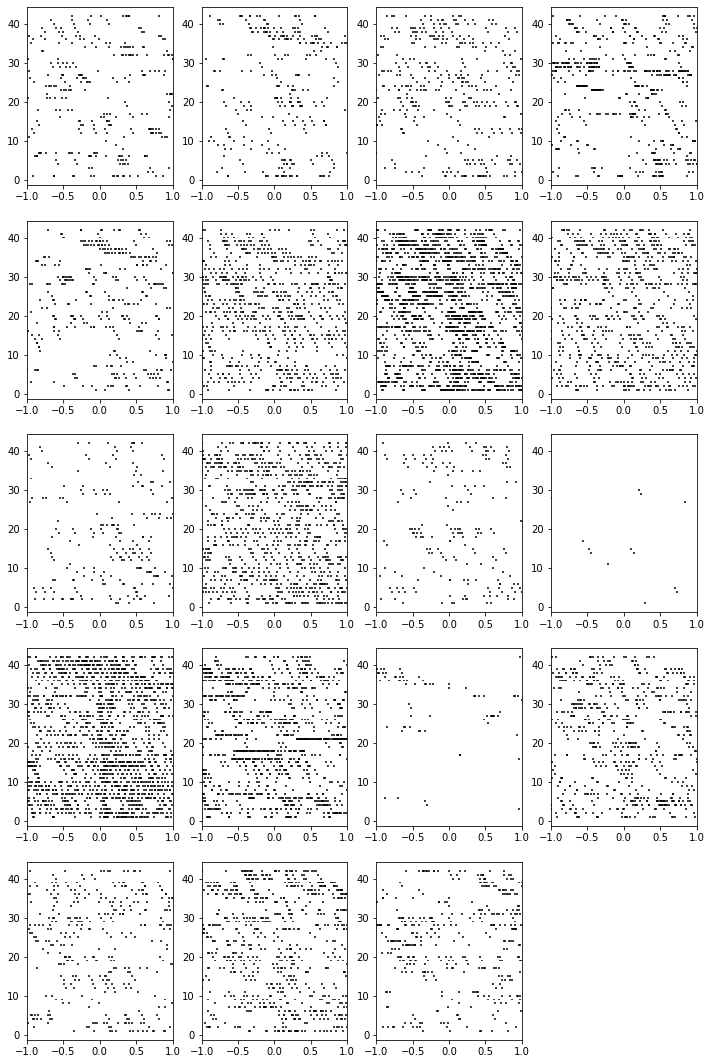

In [62]:
# rasters around positive saccades
fig = plt.figure(figsize = (12,n_units)) 
for i, ind in enumerate(goodcells.index): 
    sp = np.array(goodcells.at[units[i],'spikeT']) 
    plt.subplot(np.ceil(n_units/4),4,i+1) 
    n = 0 
    for s in upsacc: 
        n= n+1 
        sd = np.abs(sp-np.array(s))<10 
        sacc_sp = sp[sd] 
        plt.vlines(sacc_sp-np.array(s),n-0.25,n+0.25) 
    plt.xlim(-1,1); #plt.ylim(0,50)

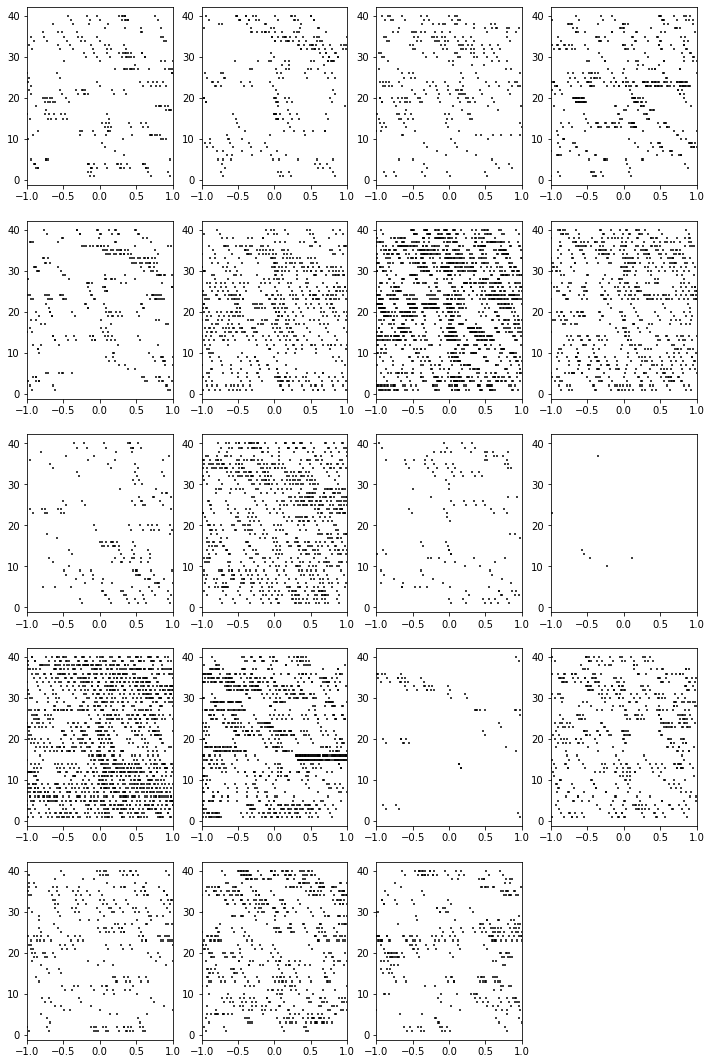

In [63]:
#rasters around negative saccades
fig = plt.figure(figsize = (12,n_units))
for i, ind in enumerate(goodcells.index):
    sp = np.array(goodcells.at[units[i],'spikeT'])
    plt.subplot(np.ceil(n_units/4),4,i+1)
    n = 0
    for s in downsacc:
        n= n+1
        sd = np.abs(sp-np.array(s))<10
        sacc_sp = sp[sd]
        plt.vlines(sacc_sp-np.array(s),n-0.25,n+0.25)
    plt.xlim(-1,1)

Text(0, 0.5, 'normalized pupil R')

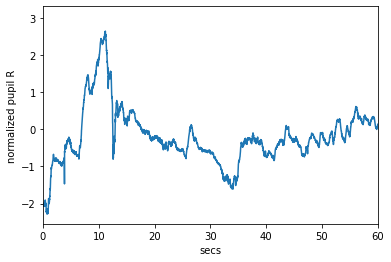

In [64]:
# normalize and plot eye radius
eyeR = eye_params.sel(ellipse_params = 'longaxis').copy()
Rnorm = (eyeR - np.mean(eyeR))/np.std(eyeR)
plt.plot(eyeT,Rnorm)
plt.xlim([0,60])
plt.xlabel('secs')
plt.ylabel('normalized pupil R')


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, '#')

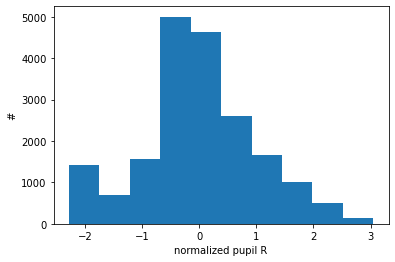

In [65]:
plt.hist(Rnorm)
plt.xlabel('normalized pupil R')
plt.ylabel('#')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


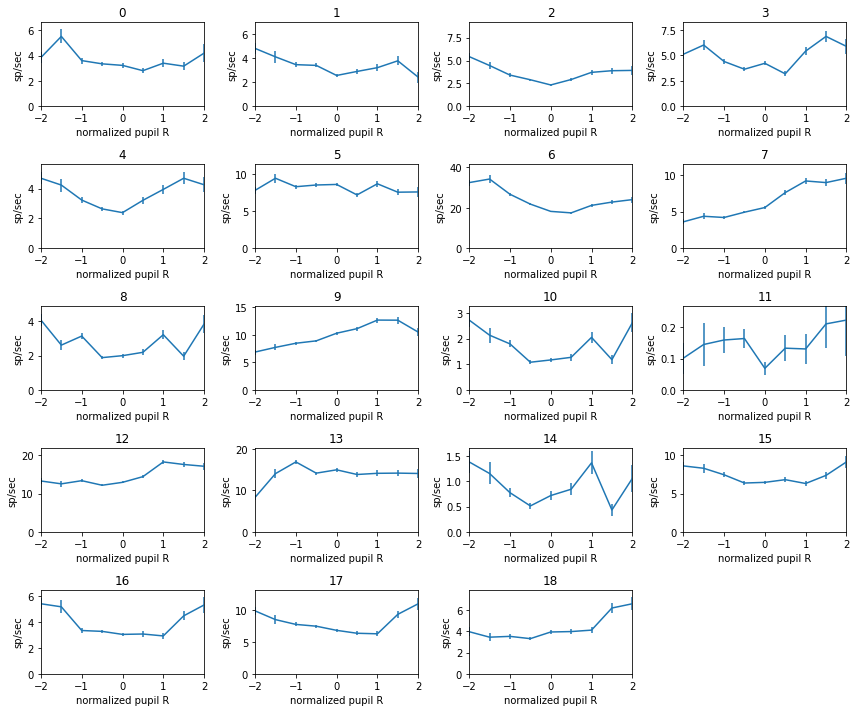

In [66]:
# plot rate vs pupil
n_units = len(goodcells)
R_range = np.arange(-4,4,0.5)
useEyeT = eyeT[(eyeT<t[-2]) & (eyeT>t[0])].copy()
useR = Rnorm[(eyeT<t[-2]) & (eyeT>t[0])].copy()
R_scatter = np.zeros((n_units,len(useR)))
R_tuning = np.zeros((n_units,len(R_range)-1))
R_tuning_err =R_tuning.copy()
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    R_scatter[i,:] = rateInterp(useEyeT)
    for j in range(len(R_range)-1):
        usePts =(useR>R_range[j]) & (useR<R_range[j+1])
        R_tuning[i,j] = np.mean(R_scatter[i,usePts])
        R_tuning_err[i,j] = np.std(R_scatter[i,usePts])/np.sqrt(np.count_nonzero(usePts))

fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
for i in range(n_units):
    plt.subplot(np.ceil(n_units/4),4,i+1)
    plt.errorbar(R_range[:-1],R_tuning[i,:],yerr=R_tuning_err[i,:])
    plt.ylim(0,np.nanmax(R_tuning[i,2:-2]*1.2))
    plt.xlim([-2, 2])
    plt.xlabel('normalized pupil R'); plt. ylabel('sp/sec'); plt.title(i)
        
        
plt.tight_layout()

plt.savefig(name_base + '_pupil_R.pdf')

Text(0, 0.5, 'normalized eye theta')

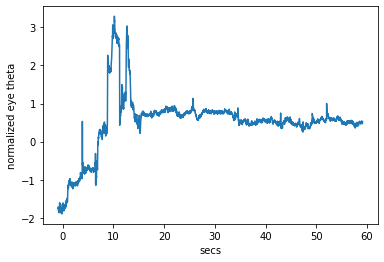

In [67]:
# normalize eye position
eyeTheta = eye_params.sel(ellipse_params = 'theta').copy()
thetaNorm = (eyeTheta - np.mean(eyeTheta))/np.std(eyeTheta)
plt.plot(eyeT[0:3600],thetaNorm[0:3600])
plt.xlabel('secs'); plt.ylabel('normalized eye theta')

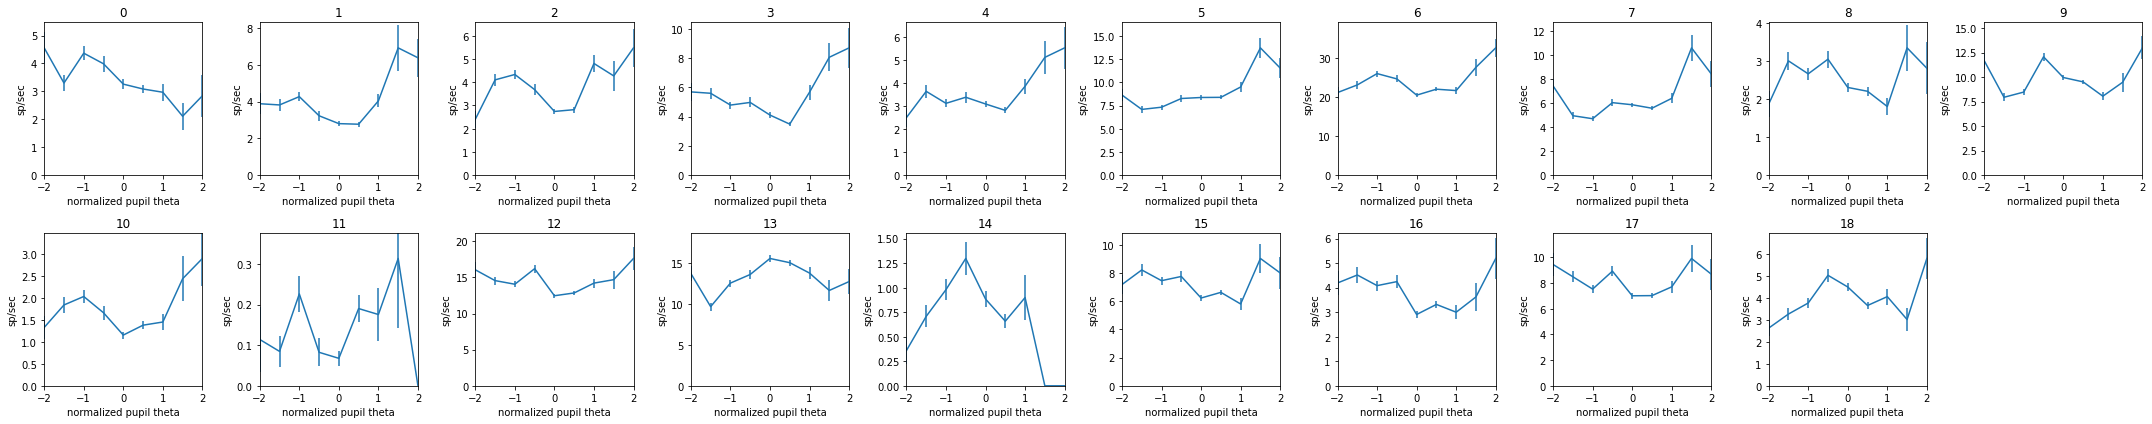

In [68]:
# plot rate vs theta
n_units = len(goodcells)
th_range = np.arange(-2,3,0.5)
useEyeT = eyeT[(eyeT<t[-2]) & (eyeT>t[0])].copy()
useTh = thetaNorm[(eyeT<t[-2]) & (eyeT>t[0])].copy()
th_scatter = np.zeros((n_units,len(useR)))
th_tuning = np.zeros((n_units,len(th_range)-1))
th_tuning_err =th_tuning.copy()
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    th_scatter[i,:] = rateInterp(useEyeT)
    for j in range(len(th_range)-1):
        usePts =(useTh>th_range[j]) & (useTh<th_range[j+1])
        th_tuning[i,j] = np.mean(th_scatter[i,usePts])
        th_tuning_err[i,j] = np.std(th_scatter[i,usePts])/np.sqrt(np.count_nonzero(usePts))

fig = plt.figure(figsize = (3*np.ceil(n_units/2),6))
for i in range(n_units):
    plt.subplot(2,np.ceil(n_units/2),i+1)
    plt.errorbar(th_range[:-1],th_tuning[i,:],yerr=th_tuning_err[i,:])
    plt.ylim(0,np.nanmax(th_tuning[i,:]*1.2))
    plt.xlim([-2, 2])
    plt.xlabel('normalized pupil theta'); plt. ylabel('sp/sec'); plt.title(i)
        
        
plt.tight_layout()

plt.savefig(name_base + '_pupil_theta.pdf')

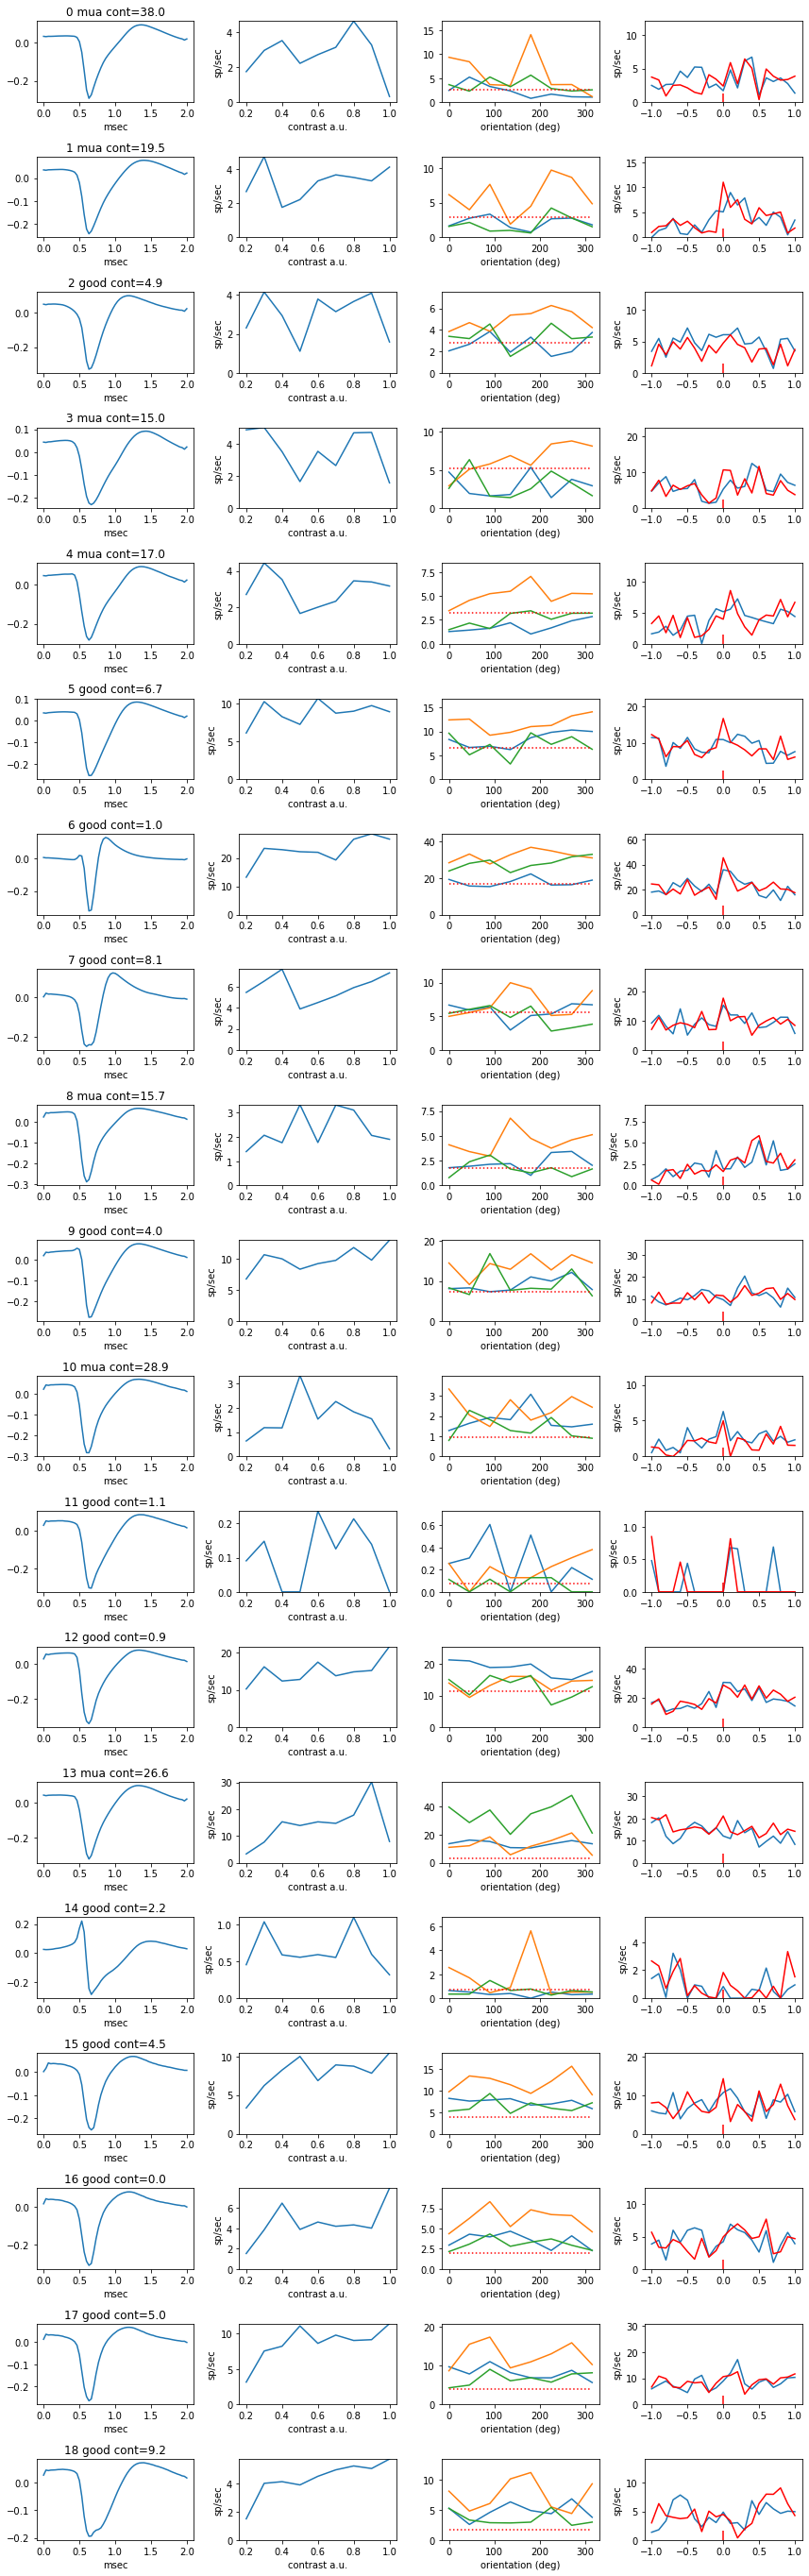

In [406]:
# generate summary plot

samprate = 30000  # ephys sample rate
plt.figure(figsize = (12,np.ceil(n_units)*2))
for i, ind in enumerate(goodcells.index): 
    # plot waveform
    plt.subplot(n_units,4,i*4 + 1)
    wv = goodcells.at[ind,'waveform']
    plt.plot(np.arange(len(wv))*1000/samprate,goodcells.at[ind,'waveform'])
    plt.xlabel('msec'); plt.title(str(i) + ' ' + goodcells.at[ind,'KSLabel']  +  ' cont='+ str(goodcells.at[ind,'ContamPct']))
    
    # plot CRF
    plt.subplot(n_units,4,i*4 + 2)
    plt.plot(crange[2:-1],resp[i,2:-1])
    plt.xlabel('contrast a.u.'); plt.ylabel('sp/sec'); plt.ylim([0,np.nanmax(resp[i,2:-1])])
                                  
    #plot STA or tuning curve
    plt.subplot(n_units,4,i*4 + 3)
    if stim_type == 'grat':
        plt.plot(np.arange(8)*45, ori_tuning[i,:,0],label = 'low sf'); plt.plot(np.arange(8)*45,ori_tuning[i,:,1],label = 'mid sf');plt.plot(np.arange(8)*45,ori_tuning[i,:,2],label = 'hi sf');
        plt.plot([0,315],[drift_spont[i],drift_spont[i]],'r:', label = 'spont')
       # plt.legend()
        plt.ylim(0,np.nanmax(ori_tuning[i,:,:]*1.2)); plt.xlabel('orientation (deg)')
    else:
        sta = staAll[i,:,:]
        staRange = np.max(np.abs(sta))*1.2
        if staRange<0.25:
            staRange=0.25
        plt.imshow(staAll[i,:,:],vmin = -staRange, vmax= staRange, cmap = 'jet')

                                  
    #plot eye movements
    plt.subplot(n_units,4,i*4 + 4)
    plt.plot(trange,upsacc_avg[i,:])
    plt.plot(trange,downsacc_avg[i,:],'r')
    plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2),'r')
    plt.ylim([0, np.max(upsacc_avg[i,:])*1.8])
    plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig(name_base + "_overview.pdf")                                 
                                 
                                  
                                  

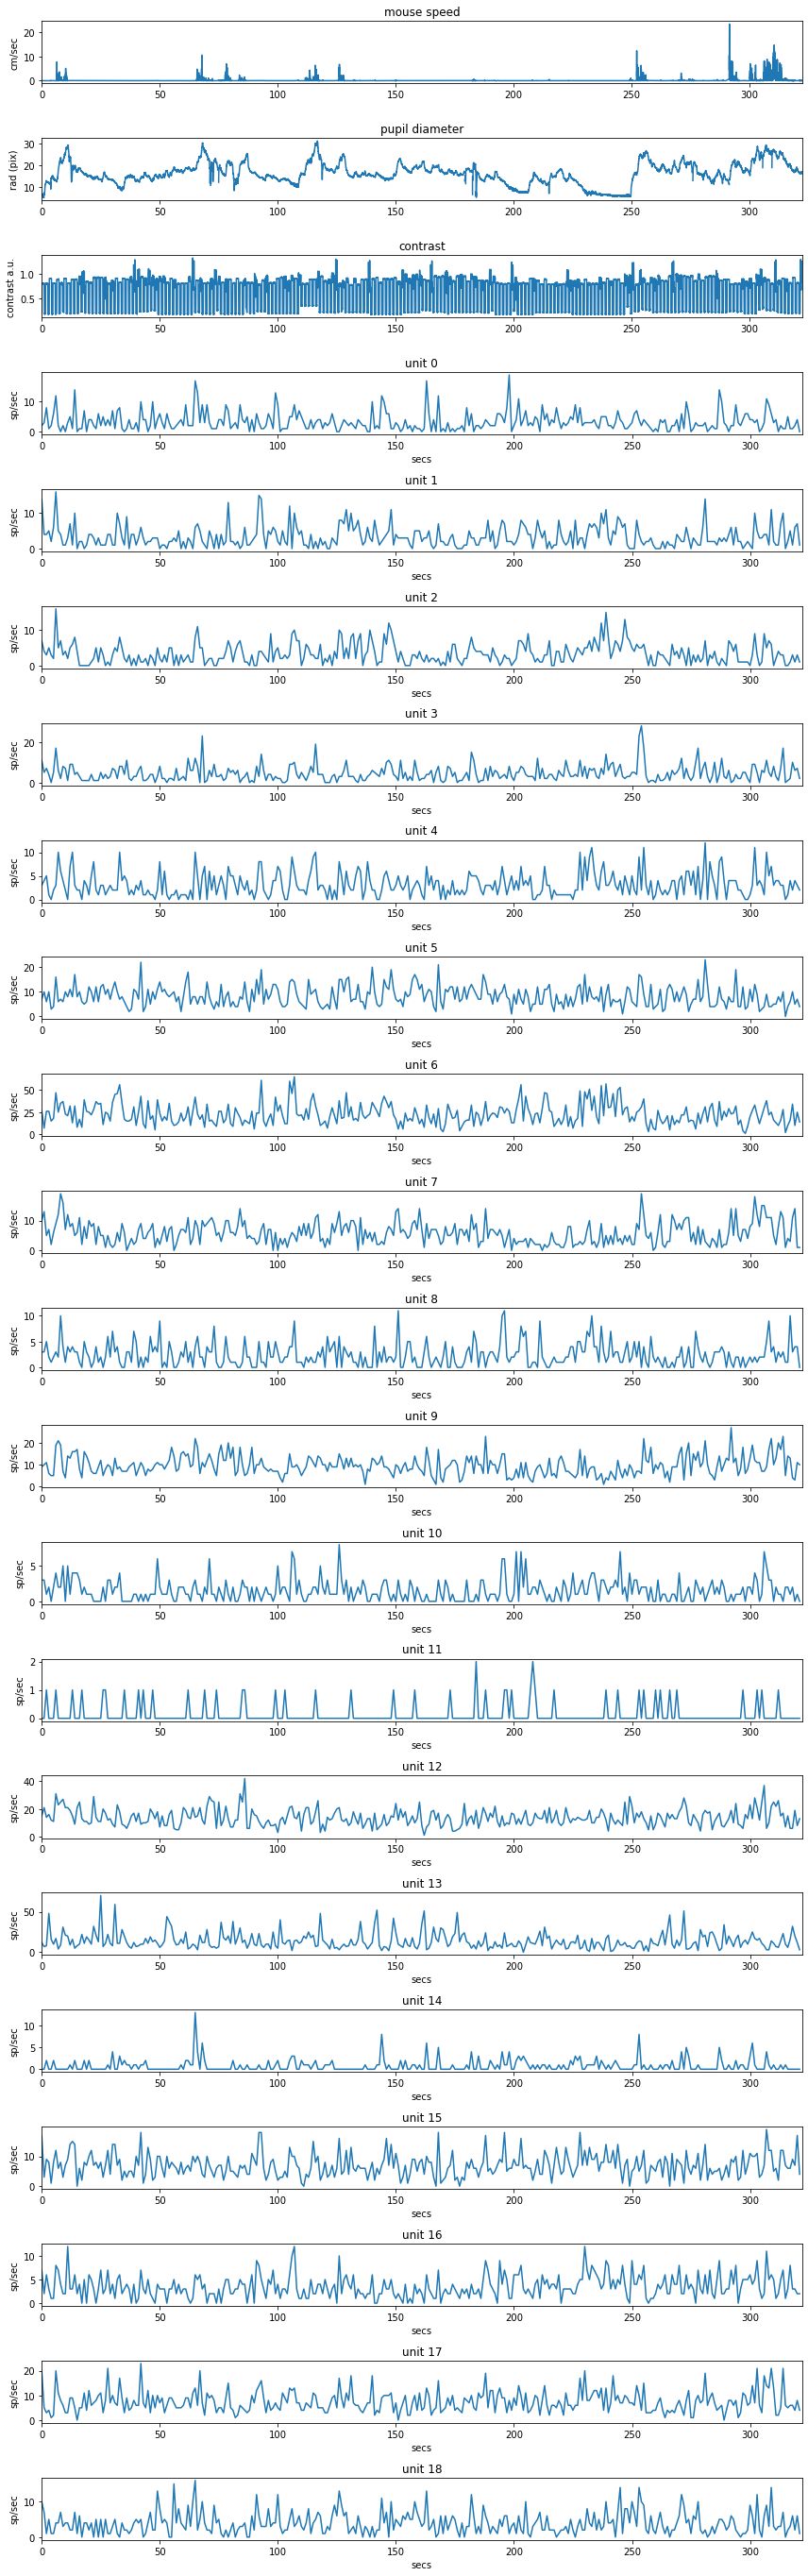

In [72]:
hist_dt = 1
hist_t = np.arange(0, np.max(worldT),hist_dt)
plt.figure(figsize = (12,n_units*2))
plt.subplot(n_units+3,1,1)
if has_imu:
    plt.plot(accT,gz)
    plt.xlim(0, np.max(worldT)); plt.ylabel('gz'); plt.title('gyro')
elif has_mouse:
    plt.plot(speedT,spd)
    plt.xlim(0, np.max(worldT)); plt.ylabel('cm/sec'); plt.title('mouse speed')  

plt.subplot(n_units+3,1,2)
plt.plot(eyeT,eye_params.sel(ellipse_params = 'longaxis'))
plt.xlim(0, np.max(worldT)); plt.ylabel('rad (pix)'); plt.title('pupil diameter')

plt.subplot(n_units+3,1,3)
plt.plot(worldT,contrast)
plt.xlim(0, np.max(worldT)); plt.ylabel('contrast a.u.'); plt.title('contrast')

for i,ind in enumerate(goodcells.index):
    rate,bins = np.histogram(ephys_data.at[ind,'spikeT'],hist_t)
    plt.subplot(n_units+3,1,i+4)
    plt.plot(bins[0:-1],rate)
    plt.xlabel('secs')
    plt.ylabel('sp/sec'); plt.xlim(bins[0],bins[-1]); plt.title('unit ' + str(i))
plt.tight_layout()
plt.savefig(name_base + '_rate.pdf')

In [ ]:
ephys_data.at[ind,'spikeT']

In [ ]:
np.shape(rate)

In [ ]:
np.arange(len(wv))